In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType, DoubleType, ArrayType
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler

from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [2]:
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ruptures as rpt
from collections import Counter
import seaborn as sns

from wordcloud import WordCloud

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[18]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

In [4]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("count", IntegerType(), True),
    StructField("bigram_percent", DoubleType(), True),
    StructField("medianA", DoubleType(), True),
    StructField("ntileA", IntegerType(), True),
    StructField("medianB", DoubleType(), True),
    StructField('ntileB', IntegerType(), True)])

In [5]:
df = spark.read.option('header', False).schema(schema).csv('/data/shared1/cleandata/all_ntiles_with0_newer')

In [8]:
df.count()

47260080

### Prepare data and make example plots

In [7]:
# collect data to np arrays
dfgrouped = df.groupBy('bigram').agg(collect_list('bigram_percent').alias('percentages'),
                              collect_list('count').alias('counts'), collect_list('ntileA').alias('ntiles_a'),
                              collect_list('ntileB').alias('ntiles_b'))

dfgrouped = dfgrouped.withColumn('peak', F.array_max('percentages'))

signal = np.array(dfgrouped.select('percentages').collect())
counts = np.array(dfgrouped.select('counts').collect())
peaks = np.array(dfgrouped.select('peak').collect())
bigrams = np.array(dfgrouped.select('bigram').collect())
ntiles_a = np.array(dfgrouped.select('ntiles_a').collect())
ntiles_b = np.array(dfgrouped.select('ntiles_b').collect())

signal_flat = np.zeros((len(signal), 120))
counts_flat = np.zeros((len(counts), 120))
peaks_flat = np.zeros((len(peaks), 120))
ntiles_a_flat = np.zeros((len(ntiles_a), 120))
ntiles_b_flat = np.zeros((len(ntiles_b), 120))
bigrams_flat = []

for i in range(len(signal)):
    signal_flat[i] = signal[i][0]
    counts_flat[i] = counts[i][0]
    peaks_flat[i] = peaks[i][0]
    ntiles_a_flat[i] = ntiles_a[i][0]
    ntiles_b_flat[i] = ntiles_b[i][0]
    bigrams_flat.append(bigrams[i][0])

In [8]:
# count how many bigrams are in each ntile A

#ntile_a_count = Counter(ntiles_a_flat.flatten())
#for i in range(1, len(ntile_a_count)+1):
#    ntile_a_count[i] = ntile_a_count[i]/120

ratio = 12161 / 41185

In [9]:
# Normalize signal_flat
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Xtranspose = np.transpose(signal_flat)

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(Xtranspose)
Xt = np.transpose(X_normalized)

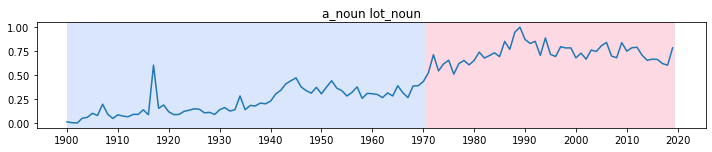

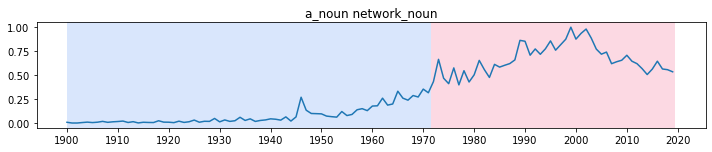

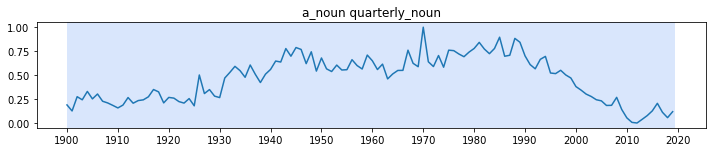

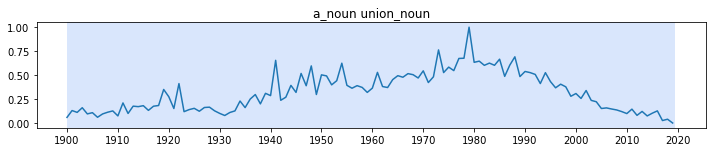

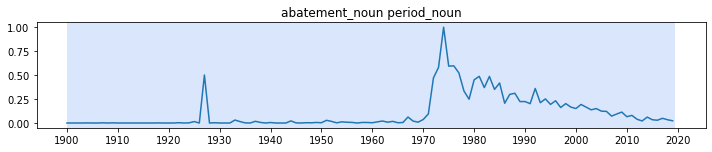

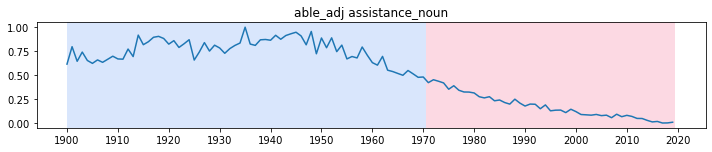

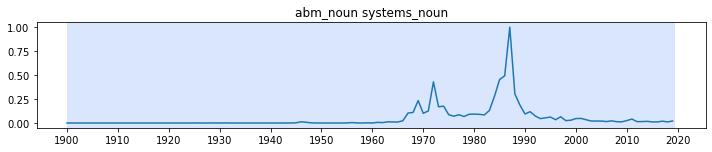

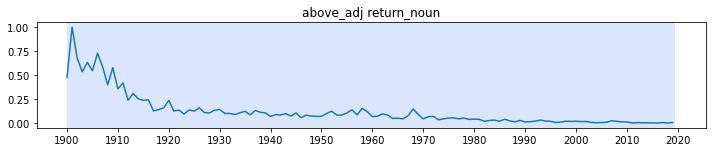

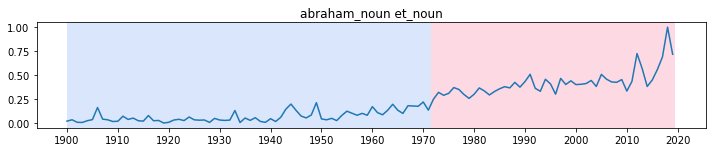

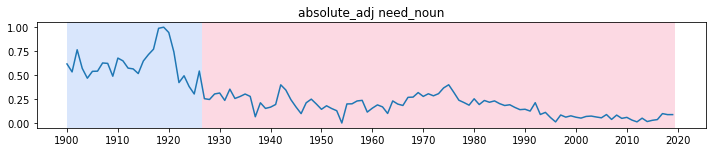

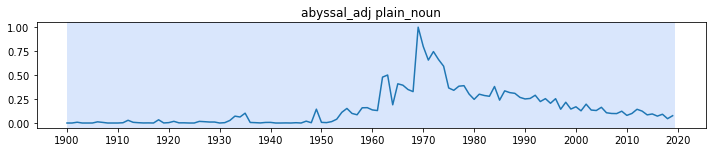

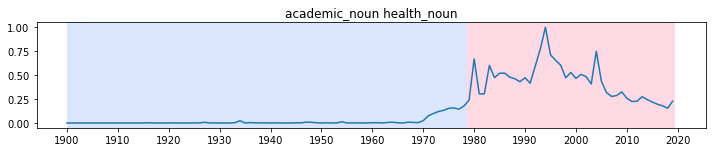

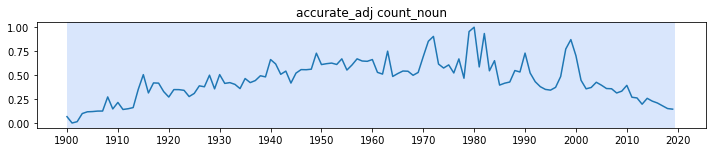

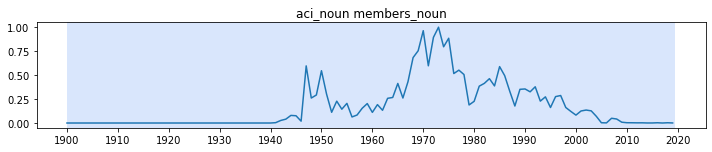

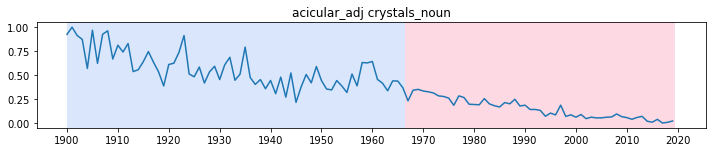

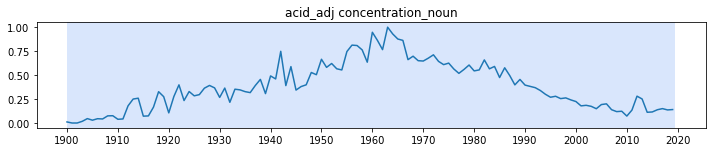

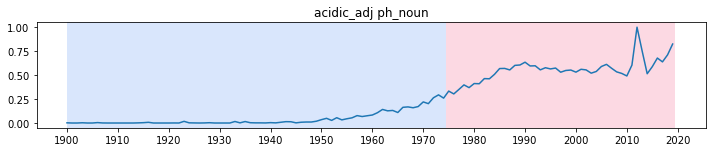

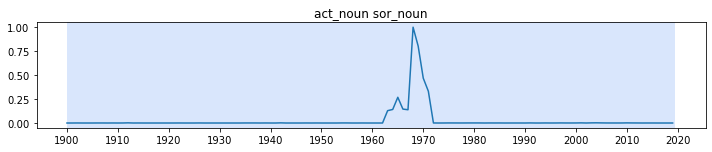

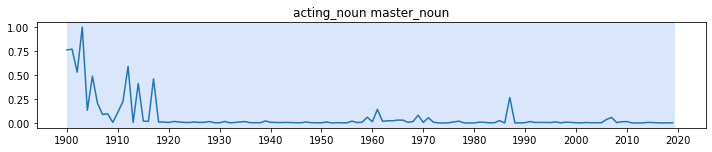

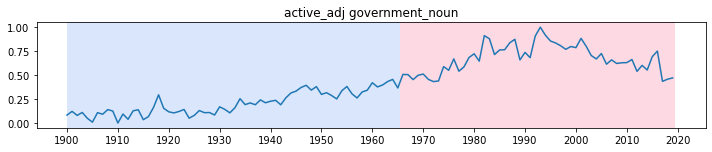

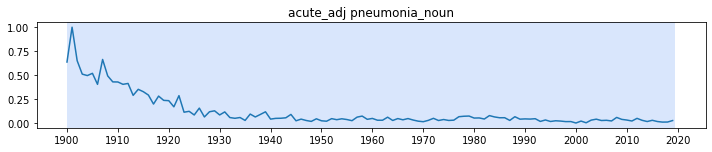

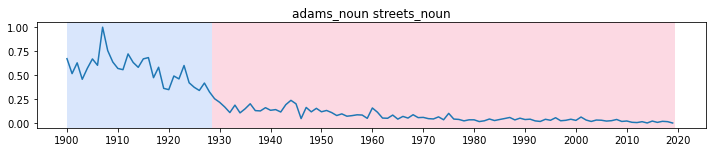

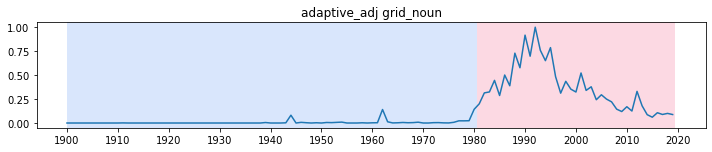

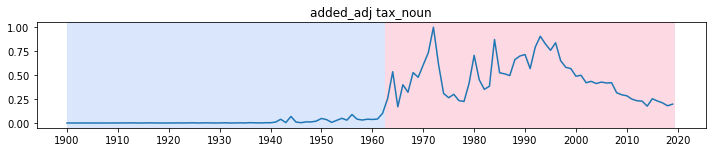

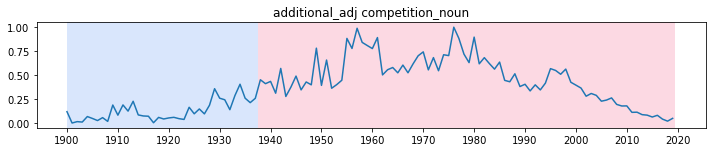

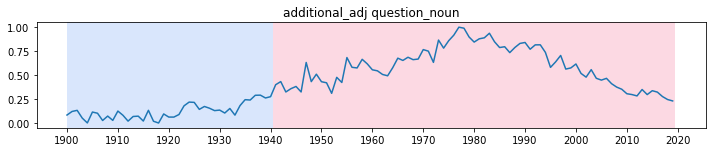

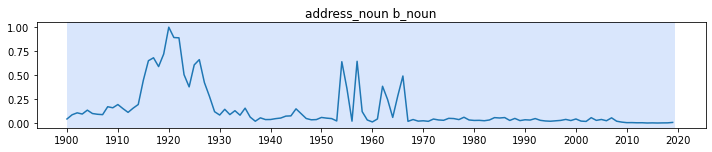

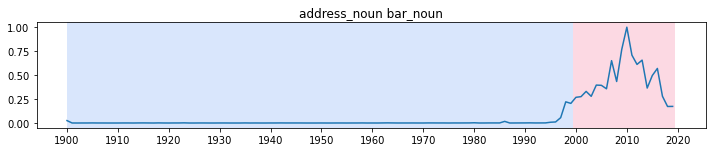

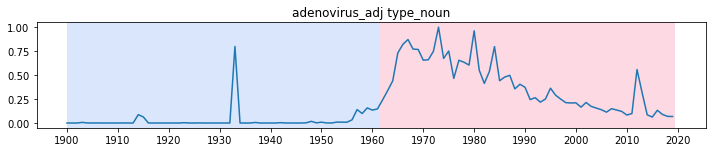

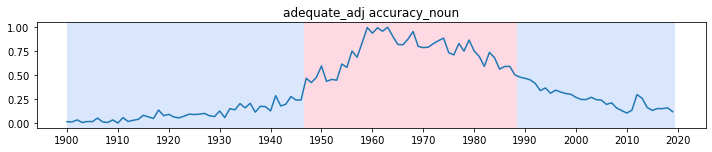

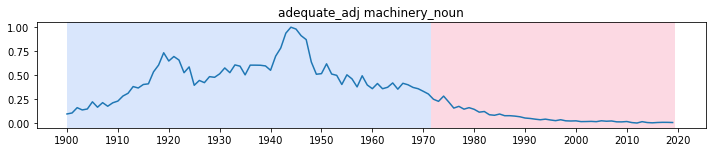

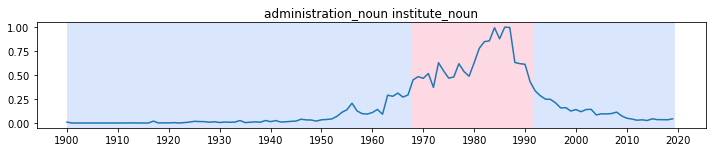

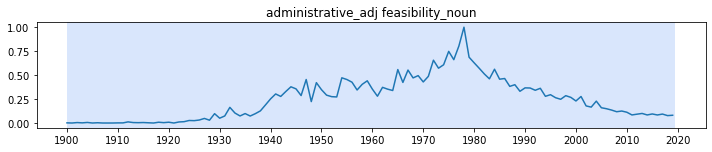

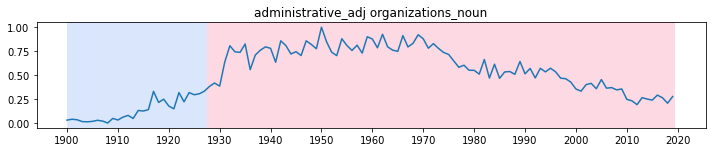

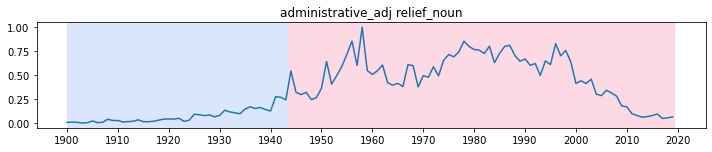

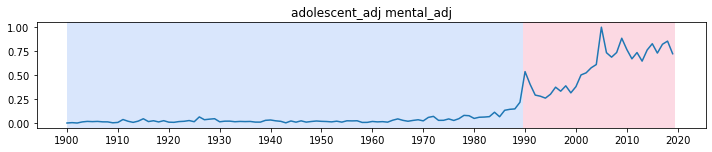

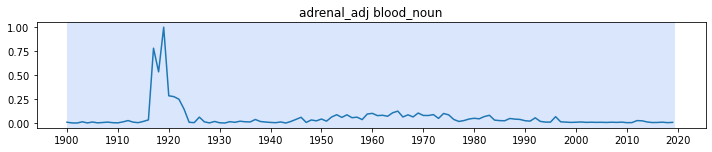

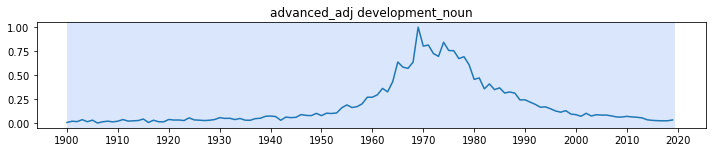

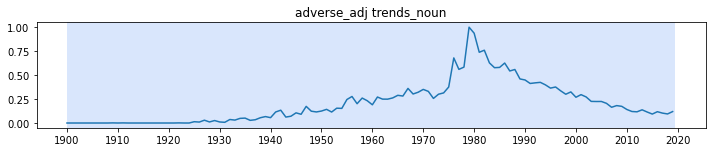

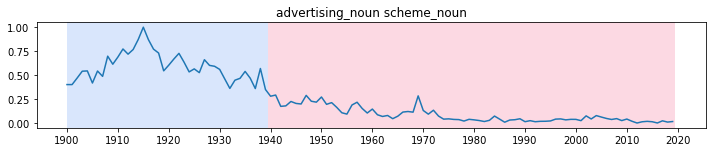

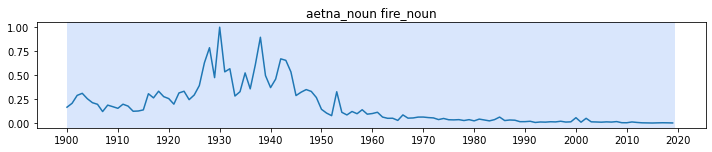

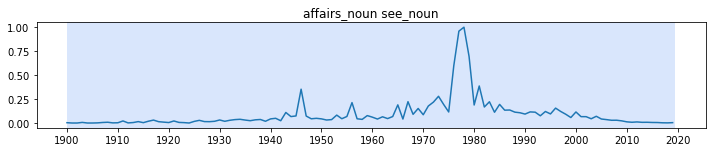

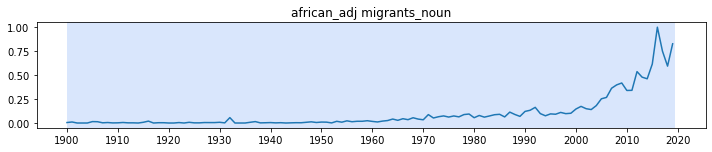

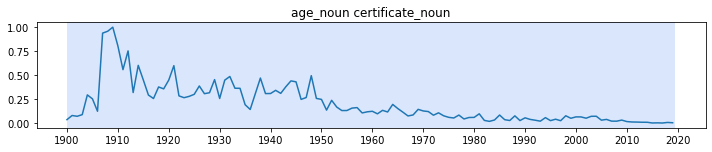

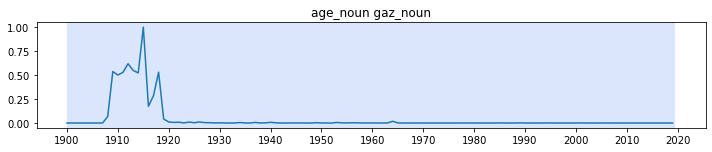

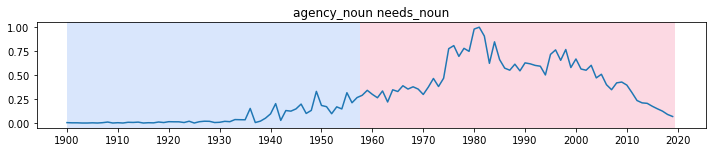

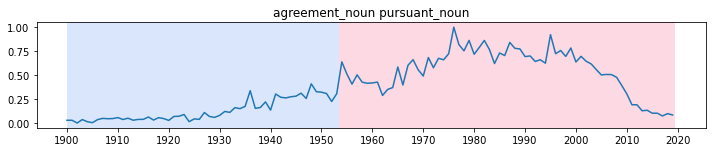

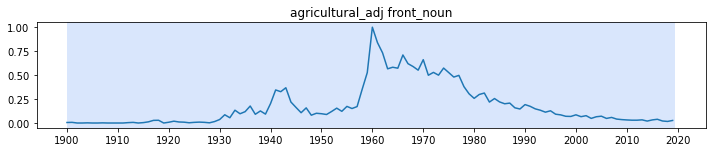

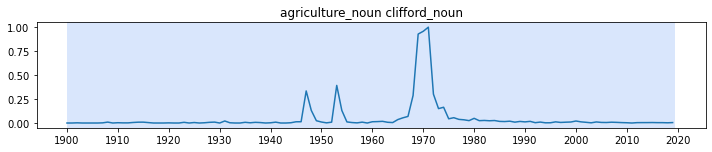

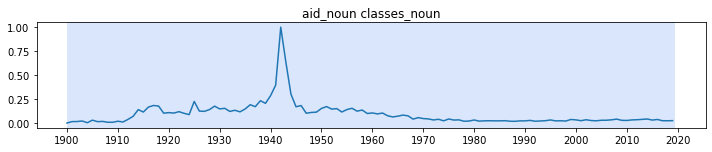

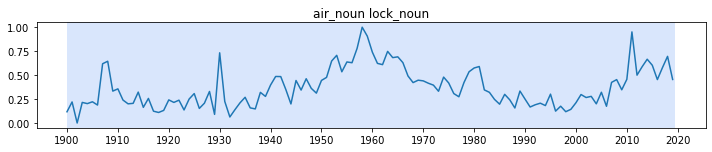

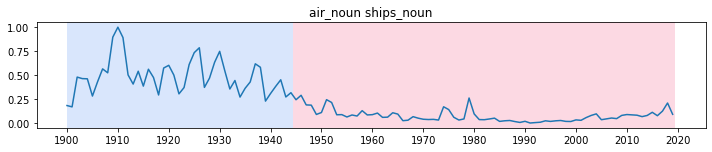

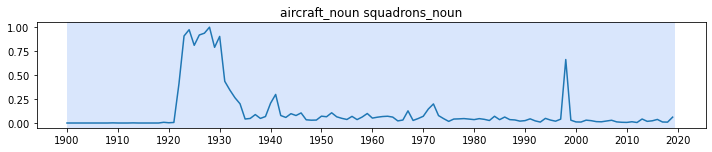

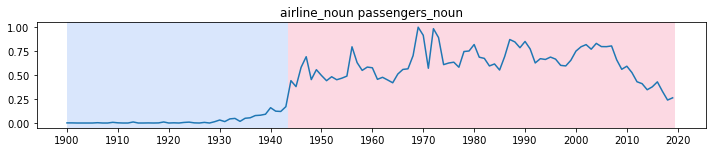

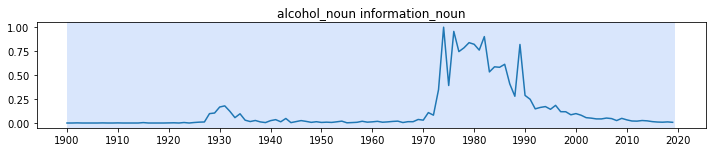

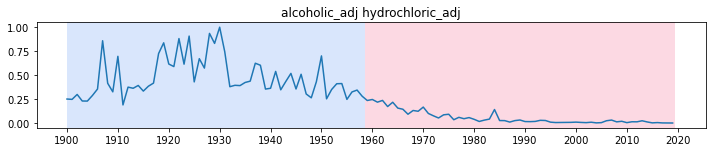

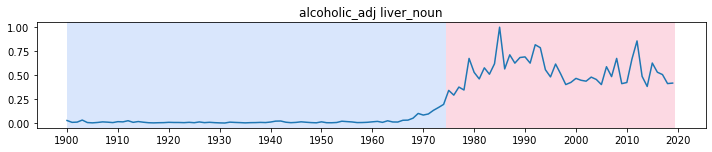

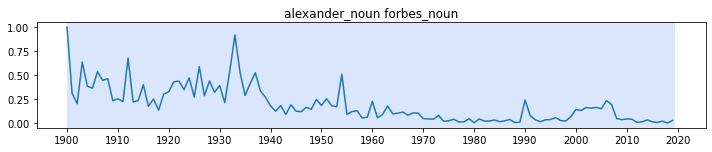

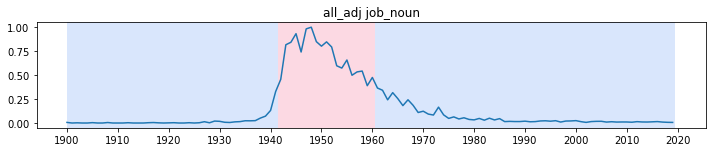

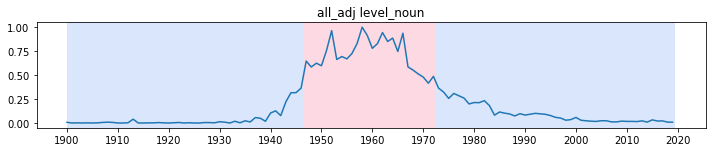

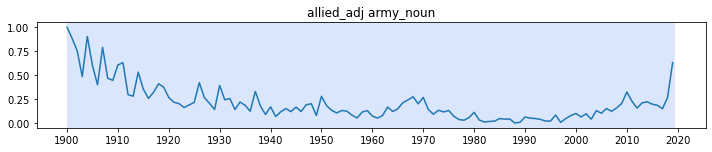

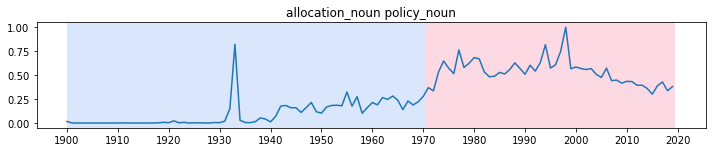

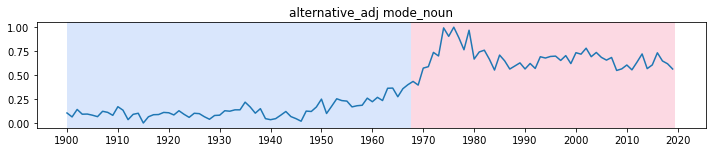

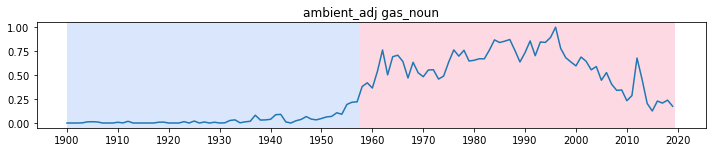

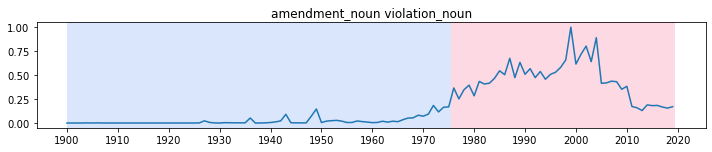

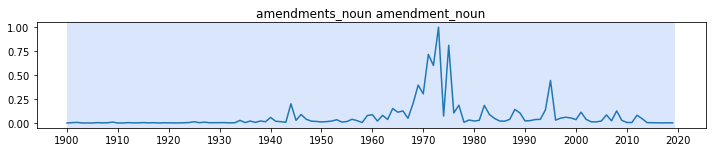

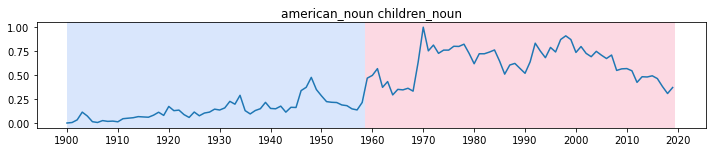

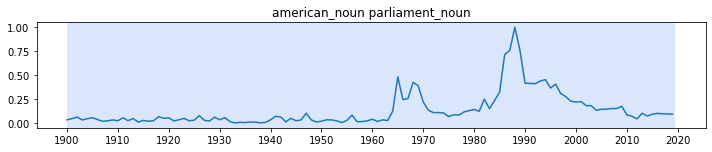

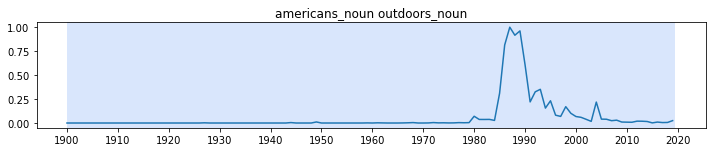

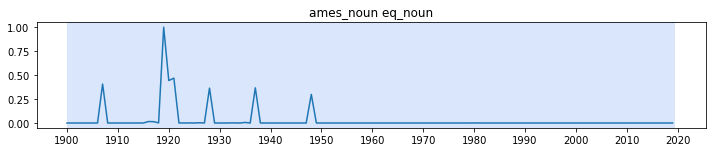

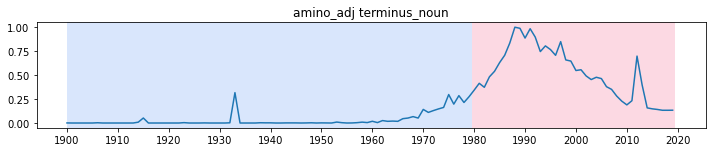

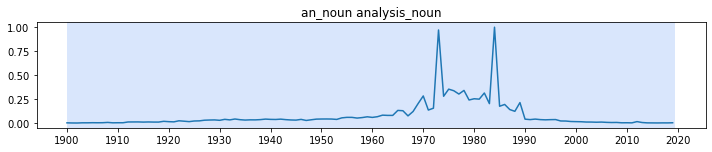

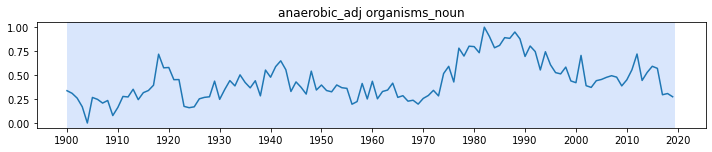

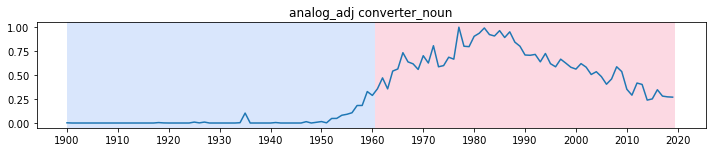

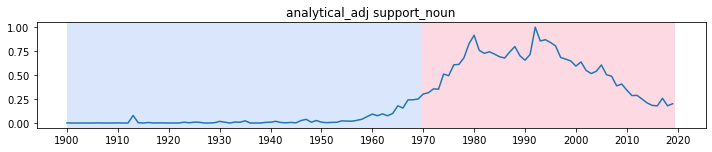

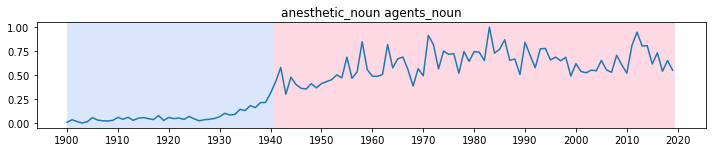

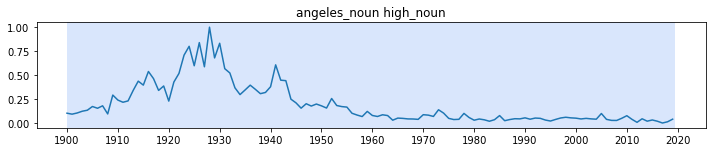

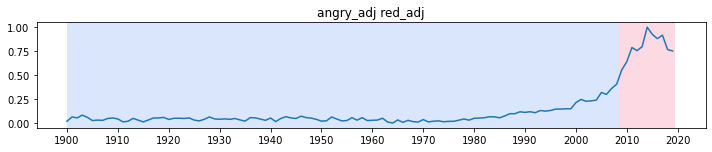

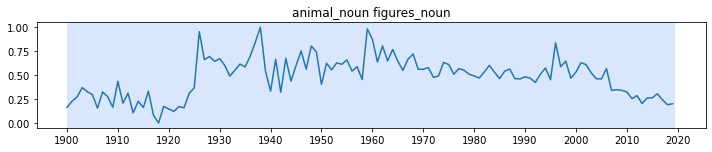

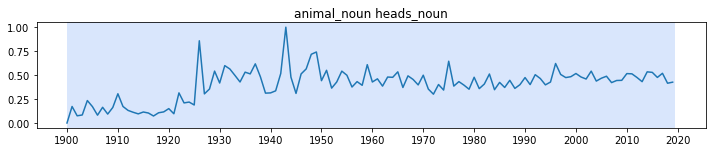

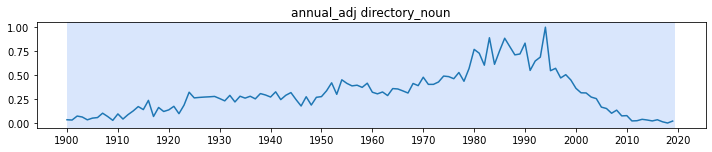

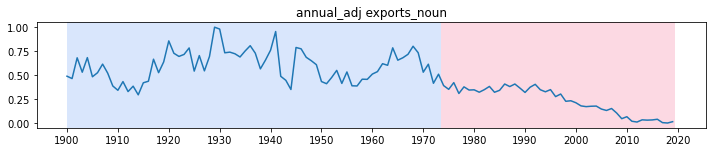

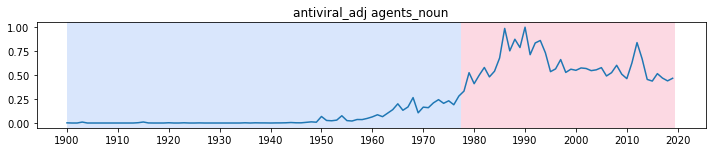

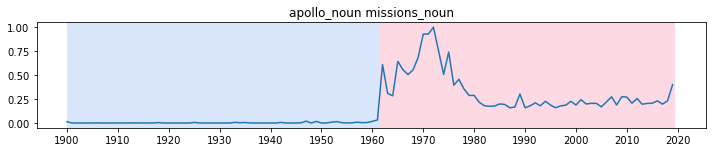

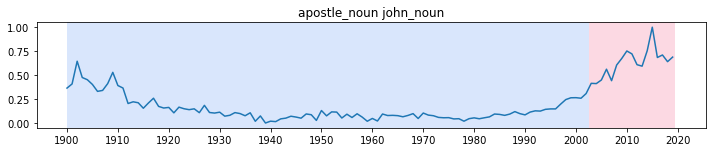

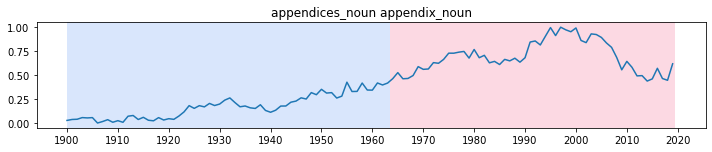

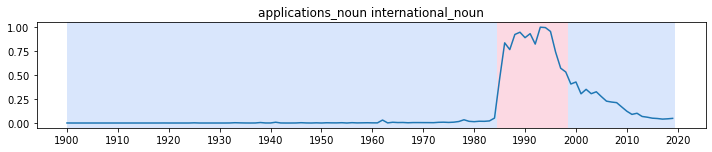

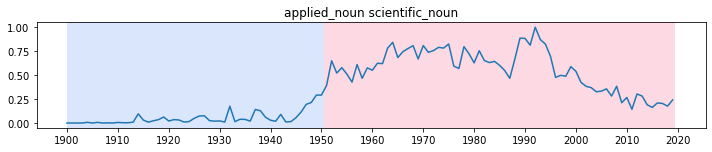

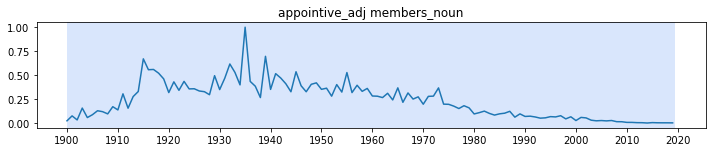

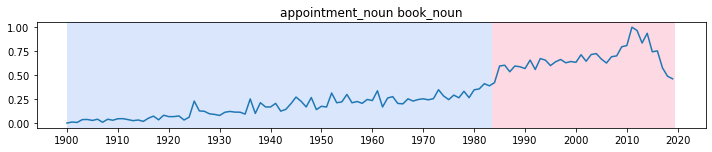

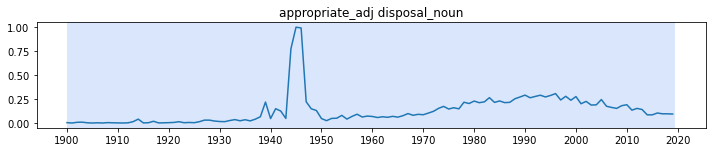

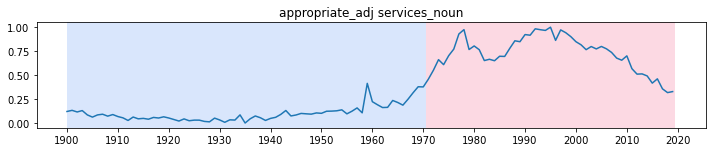

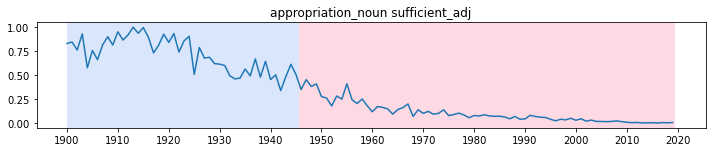

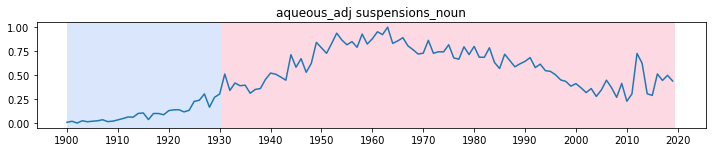

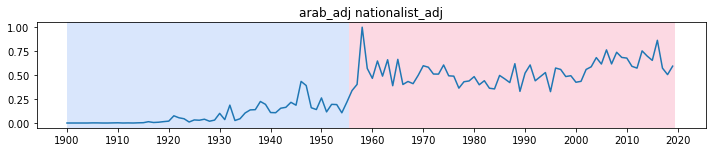

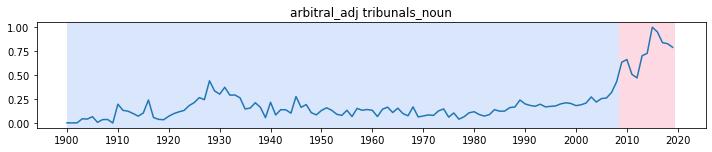

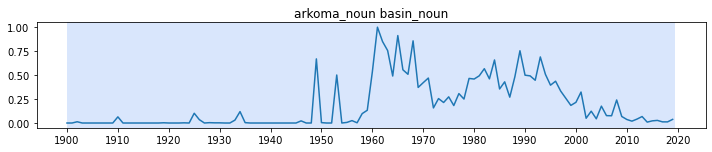

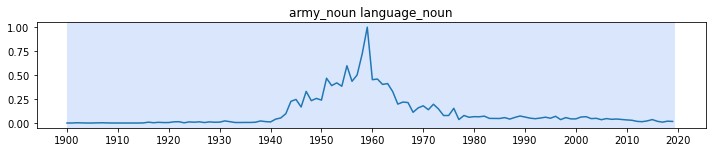

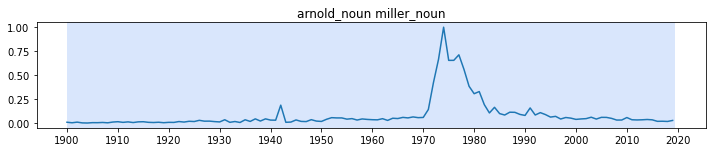

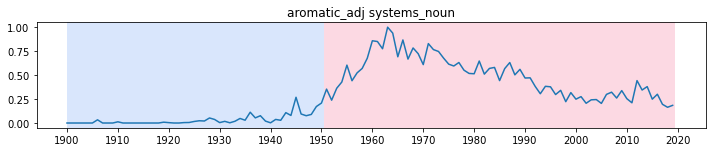

In [10]:
# generate a few plots to look at

for i in range(0, 100):
    algo = rpt.KernelCPD(kernel="linear", min_size=2).fit(Xt[i]) 
    penalty_value = 3
    result = algo.predict(pen=penalty_value)
    
    rpt.display(Xt[i], result) 
    
    x = np.arange(0,121,10)
    xlabels = np.arange(1900,2021,10)
    plt.xticks(x, labels=xlabels)
    plt.title(bigrams[i][0])
    
    plt.show()

### Number of changepoints for different penalties

Note that this is number of changepoints for all bigrams, and not just the mainstream ones - should we make this plot on the mainstream bigrams instead? 

In [11]:
penaltyDict = dict()
penalties = [1, 3, 5, 7]
changepointLenghts = dict()

for p in penalties:
    changepoints = 0
    changepoint_lengths = []
    for i in range(0, len(signal_flat)):
        algo = rpt.KernelCPD(kernel="linear", min_size=2).fit(Xt[i])
        result = algo.predict(pen=p)
        changepoints += len(result) - 1
        changepoint_lengths.append(len(result) - 1)
    penaltyDict[p] = changepoints
    changepointLenghts[p] = changepoint_lengths

In [12]:
keys = list(changepointLenghts.keys())
vals = list(changepointLenghts.values())

count = []
for i in range(0, len(vals)):
    count.append(Counter(list(changepointLenghts.values())[i]))

In [13]:
changepointCountDict = dict()
for i in range(0, len(count)):
    countlist = []
    for j in range(0, 10):
        countlist.append(count[i][j])
    changepointCountDict[keys[i]] = countlist

In [14]:
changepointCountDict

{1: [33110, 190046, 163870, 6712, 96, 0, 0, 0, 0, 0],
 3: [165549, 216861, 11423, 1, 0, 0, 0, 0, 0, 0],
 5: [261774, 131876, 184, 0, 0, 0, 0, 0, 0, 0],
 7: [326823, 67011, 0, 0, 0, 0, 0, 0, 0, 0]}

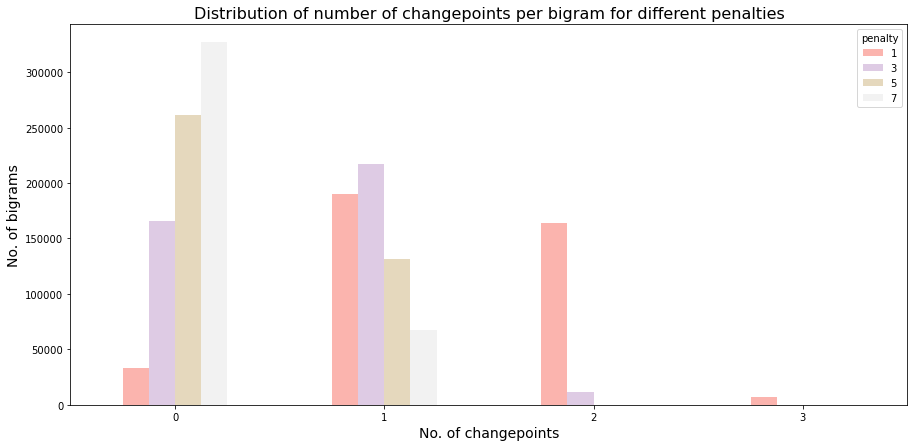

In [15]:
plotpd = pd.DataFrame(changepointCountDict)
plotpd.plot(kind='bar', figsize=(15,7), colormap = 'Pastel1')
plt.title('Distribution of number of changepoints per bigram for different penalties', fontsize=16)
plt.xlabel('No. of changepoints', fontsize=14)
plt.ylabel('No. of bigrams', fontsize=14)
plt.xlim(-0.5,3.5)
plt.xticks(rotation=0)
plt.legend(title='penalty')
plt.savefig('changepoint_counts',bbox_inches='tight')
plt.show()

###  Changepoint annotation and heatmap generation

In [11]:
def changepoint_annotation(penalty, threshold):
    breakpointDict = dict() # dict containing bigram as key and breakpoints as values
    peakDict = dict() # dict containing bigram as key and peaks as values
    countDict = dict() # dict containing bigram as key and count in peak as values

    for i in range(0, len(signal_flat)):
        algo = rpt.KernelCPD(kernel="linear", min_size=2).fit(Xt[i])
        result = algo.predict(pen=penalty)
        result.insert(0, 0)
        breakpointDict[bigrams_flat[i]] = (result, (int(ntiles_a_flat[i][0]), int(ntiles_b_flat[i][0])))
        peakDict[bigrams_flat[i]] = (np.where(signal_flat[i] == peaks[i])[0][0],peaks[i][0])
        countDict[bigrams_flat[i]] = counts_flat[i][peakDict[bigrams_flat[i]][0]]
        
    # label bigrams as 1 if a bigram has a change point and the peak is over 1e-5
    label0 = dict()
    label1 = dict()

    for key, val in breakpointDict.items():
        if ((len(val[0]) > 2) & (peakDict[key][1] > threshold)):
            label1[key] = val
        else:
            label0[key] = val
            
    # Filter the bigrams with changepoints
    # The changepoint should be before the peak and when the timeseries increases
    mainstreamNgrams = dict() 

    for key in label1.keys():
        for i in range(1, len(label1[key][0])-1):
            if (label1[key][0][i] < peakDict[key][0]):
                mainstreamNgrams[key] = label1[key]
                
    # find breakpoints around peak (mainstream period), only for the mainstream bigrams

    mainstreamPeriodDict = dict() # dict containing start and end for mainstream period, and peak

    for key in mainstreamNgrams.keys():
        for i in range(len(mainstreamNgrams[key][0])-1):
            if (mainstreamNgrams[key][0][i] <= peakDict[key][0]) & (mainstreamNgrams[key][0][i+1] >= peakDict[key][0]):
                mainstreamPeriodDict[key] = [mainstreamNgrams[key][0][i]+1900, peakDict[key][0]+1900, mainstreamNgrams[key][0][i+1]+1900]
                
    # Delete the ngrams with mainstream period under five years
    for key, val in mainstreamPeriodDict.copy().items():
        if val[2] - val[0] < 5:
            del mainstreamPeriodDict[key]
            del mainstreamNgrams[key]      
            
    return breakpointDict, peakDict, countDict, label0, label1, mainstreamNgrams, mainstreamPeriodDict

In [18]:
def generate_heatmap_matrix(mainstreamNgrams):
    ntiles_label1 = []
    for key, val in mainstreamNgrams.items():
        ntiles_label1.append(val[1])
        
    # make dictionary containing all possible ntile combinations
    ntile_combinations = dict()
    for i in range(1, 31):
        for j in range(1, 31):
            ntile_combinations[(i, j)] = 0
            
    for comb in ntiles_label1:
        ntile_combinations[comb] = ntile_combinations[comb] + 1
        
    # divide all ntile_combinations starting with 1 such that they have the same scale as other ntiles
    for comb in ntile_combinations:
        if comb[0] == 1:
            ntile_combinations[comb] = int(ntile_combinations[comb] * (12161 / 41185))
            
    # Save the values in a list
    value = []
    for key, val in sorted(ntile_combinations.items()):
        value.append(val)

    # numpy matrix to the plot
    matrix = np.array(value).reshape(30,30) 
    
    return matrix, ntile_combinations

In [19]:
# make some different penalty and threshold combinations
penalties = [1, 3, 5, 10]
thresholds = [0.7e-5, 1e-5, 1.5e-5, 3e-5]
param = []

for p in penalties:
    for t in thresholds:
        param.append((p, t))

In [20]:
# generate matrices for heatmaps
matrices = []

for i in range(0, 16):
    # find mainstream bigrams for different combinations of p and t
    breakpointDict, peakDict, countDict, label0, label1, mainstreamNgrams, mainstreamPeriodDict = changepoint_annotation(param[i][0], param[i][1])
    
    # generate matrices from dict containing mainstream bigrams
    matrix, ntile_combinations = generate_heatmap_matrix(mainstreamNgrams)
    matrices.append(matrix)

<Figure size 432x288 with 0 Axes>

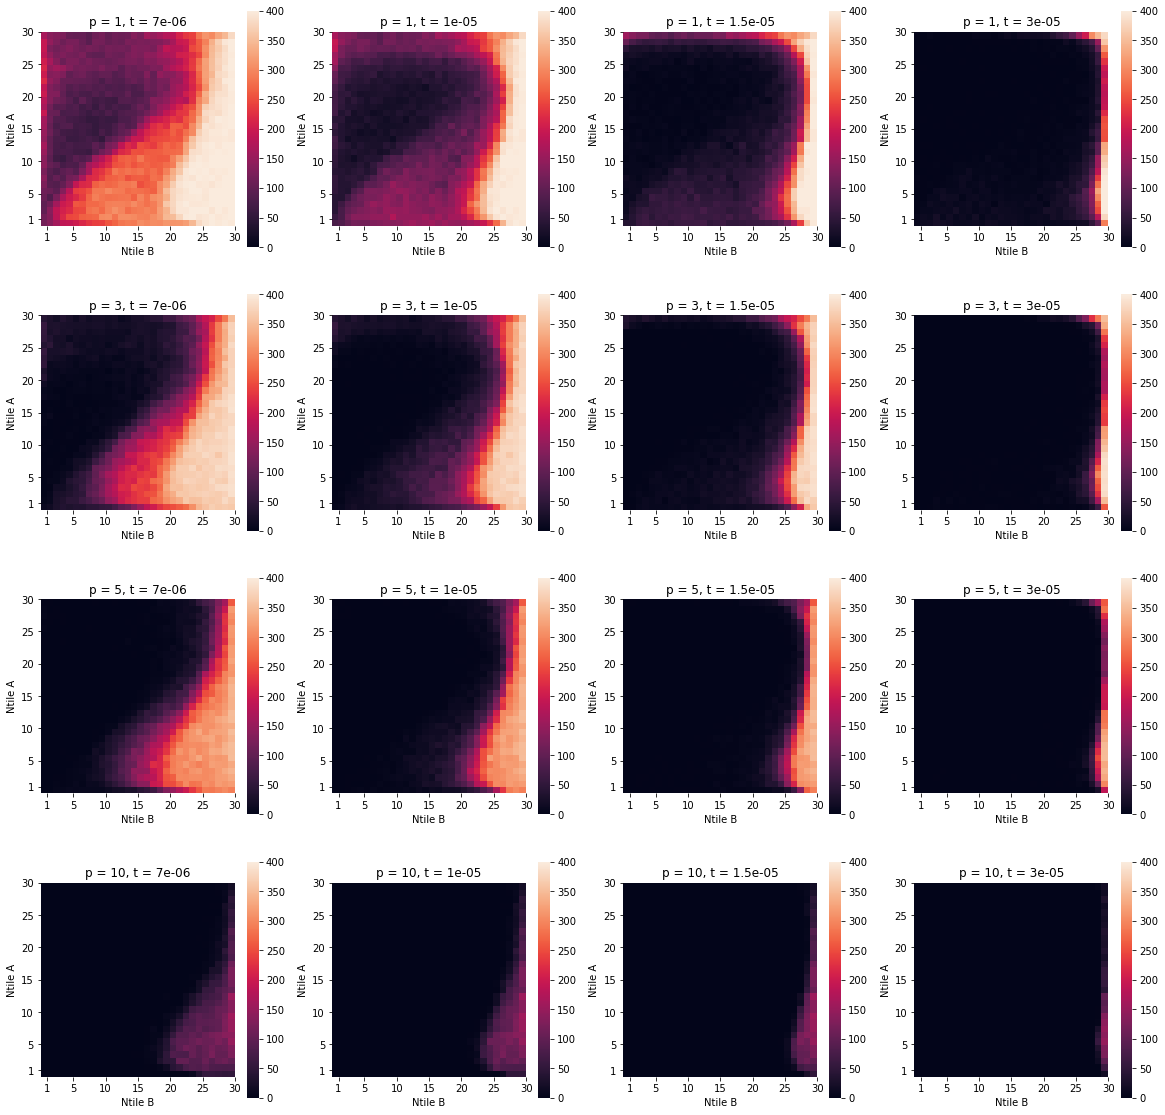

In [21]:
# plot heatmaps
fig = plt.figure()
plt.figure(figsize=(20,20))
#plt.title('Heatmaps showing number of mainstream bigrams for each ntile combination, for different penalties and thresholds')

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    ticks = [1, 5, 10, 15, 20, 25, 30]
    ax = sns.heatmap(matrices[i], vmin=0, vmax=400, square=True)
    
    plt.title('p = ' + str(param[i][0]) + ', t = ' + str(param[i][1]), fontsize=12)
    plt.ylabel('Ntile A')
    plt.xlabel('Ntile B')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticklabels(ticks)
    ax.invert_yaxis()  
    
plt.savefig('heatmaps',bbox_inches='tight')
plt.show()

In [12]:
# for penalty = 3, threshold = 1e-5
breakpointDict, peakDict, countDict, label0, label1, mainstreamNgrams, mainstreamPeriodDict = changepoint_annotation(3, 1e-5)

# generate matrix from dict containing mainstream bigrams
matrix, ntile_combinations = generate_heatmap_matrix(mainstreamNgrams)

<Figure size 432x288 with 0 Axes>

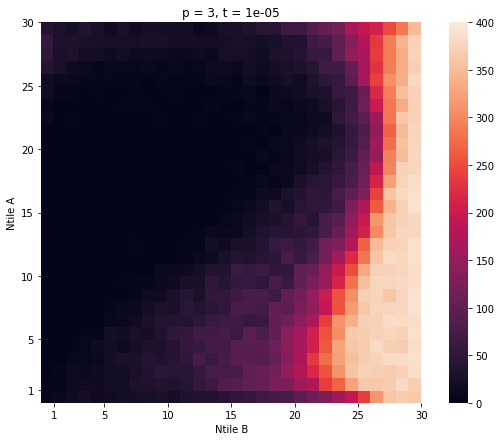

In [13]:
# generate large version of selected heatmap
fig = plt.figure()
plt.figure(figsize=(10,7))
#plt.title('Heatmaps showing number of mainstream bigrams for each ntile combination, for different penalties and thresholds')

ticks = [1, 5, 10, 15, 20, 25, 30]
ax = sns.heatmap(matrix, vmin=0, vmax=400, square=True)

plt.title('p = ' + str(3) + ', t = ' + str(1e-5), fontsize=12)
plt.ylabel('Ntile A')
plt.xlabel('Ntile B')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
ax.set_yticks(ticks)
ax.set_xticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticklabels(ticks)
ax.invert_yaxis()  
    
#plt.savefig('selected_heatmap', bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

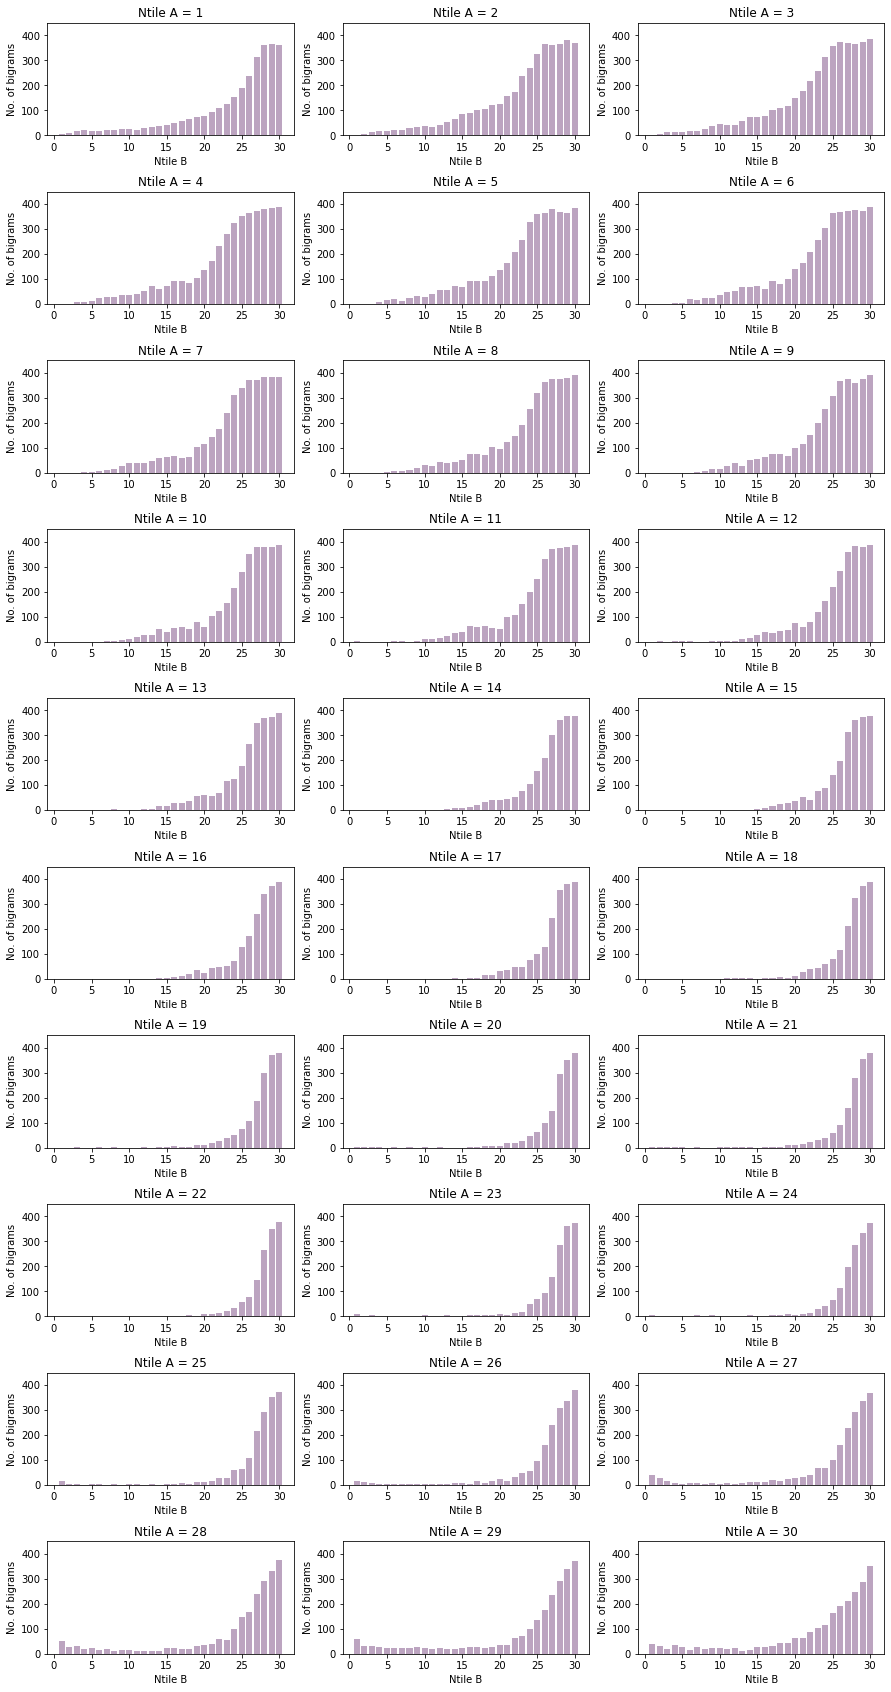

In [14]:
# barplot showing number of mainstream bigrams in each ntile combination 

fig = plt.figure()
plt.figure(figsize=(15,30))

for i in range(1, 31):
    plotdict = dict()
    for key in ntile_combinations:
        if key[0] == i:
            plotdict[key[1]] = ntile_combinations[key]
            
    plt.subplot(10, 3, i)
    plt.subplots_adjust(hspace = 0.5)
    plotpd = pd.DataFrame.from_dict(plotdict, orient='index', columns=['ntile_count'])
    plt.bar(plotpd.index, plotpd.ntile_count, color='#BCA4C0')
    plt.title('Ntile A = ' + str(i))
    plt.xlabel('Ntile B')
    plt.ylabel('No. of bigrams')
    plt.ylim([0, 450])


plt.savefig('mainstream_distribution_plots_appendix', bbox_inches='tight')

plt.show()

### Annotated dataframe

In [14]:
def generate_annotated_dataframe(mainstreamNgrams, mainstreamPeriodDict, peakDict):
    annotated = df.withColumn('label', when(F.col('bigram').isin(list(mainstreamNgrams.keys())), 1).\
                            when(~(F.col('bigram').isin(list(mainstreamNgrams.keys()))), 0))
    
    # make a dict with the bigram and the breakpoint before the peak
    startOfMainstreaming = dict()
    endOfMainstreaming = dict()
    for key, val in mainstreamPeriodDict.items():
        startOfMainstreaming[key] = val[0]
        endOfMainstreaming[key] = val[2]
    
    # make dict with peak years for all bigrams
    peak_years = dict()
    for key, val in peakDict.items():
        peak_years[key] = val[0] + 1900
        
    mainstreamingList = list(zip(list(map(str, startOfMainstreaming.keys())),
                             list(map(int, startOfMainstreaming.values())),
                             list(map(int, endOfMainstreaming.values()))))
    
    peak_year_list = list(zip(list(map(str, peak_years.keys())),
                         list(map(int, peak_years.values()))))
    
    # create pyspark dataframe with the mainstreaming breakpoint and end of mainstreaming
    schema1 = StructType([
        StructField("bigram", StringType(), True),
        StructField("start_of_mainstreaming", IntegerType(), True),
        StructField("end_of_mainstreaming", IntegerType(), True)])
    
    mainstreamingdf = spark.createDataFrame(mainstreamingList, schema1)
    
    # create pyspark dataframe with the peak year for all bigrams
    schema2 = StructType([
        StructField("bigram", StringType(), True),
        StructField("peak_year", IntegerType(), True)])
    
    peakdf = spark.createDataFrame(peak_year_list, schema2)
    
    annotated = annotated.join(mainstreamingdf, ['bigram'], how = 'full')
    
    annotated = annotated.join(peakdf, ['bigram'], how='inner')
    
    return annotated

In [12]:
breakpointDict, peakDict, countDict, label0, label1, mainstreamNgrams, mainstreamPeriodDict = changepoint_annotation(3, 1e-5)

KeyboardInterrupt: 

In [15]:
annotated = generate_annotated_dataframe(mainstreamNgrams, mainstreamPeriodDict, peakDict)

### Save dataframe

In [83]:
annotated.write.csv('/data/shared1/cleandata/changepoint_annotated_allntiles_newer')

In [79]:
annotated.printSchema()

root
 |-- bigram: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- bigram_percent: double (nullable = true)
 |-- medianA: double (nullable = true)
 |-- ntileA: integer (nullable = true)
 |-- medianB: double (nullable = true)
 |-- ntileB: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- start_of_mainstreaming: integer (nullable = true)
 |-- end_of_mainstreaming: integer (nullable = true)
 |-- peak_year: integer (nullable = true)



### Trajectory plots

In [80]:
label0pd = annotated.where(col('label') == 0).limit(120*100).toPandas()
label1pd = annotated.where(col('label') == 1).limit(120*100).toPandas()

In [86]:
def plot_data(model):
    #bigrams = list(model['bigram'].sample(n=100).unique())
    bigrams = model['bigram'].unique()

    for i in range(0, len(bigrams)): 
        tmp = model[model['bigram'] == bigrams[i]]
        tmp = tmp.reset_index()
        
        if tmp.label[i] == 0:
            rpt.display(tmp.bigram_percent.values, [120])
            
        if tmp.label[i] == 1:
            rpt.display(tmp.bigram_percent.values, [tmp.start_of_mainstreaming[i]-1900, tmp.end_of_mainstreaming[i]-1900, 2020-1900])
            #plt.savefig('label' + str(tmp.label[i]) + '_ntile' + str(n) + '.png', bbox_inches = "tight")
            plt.axvline(x=tmp.peak_year[i]-1900, color='salmon', linestyle='--')
            
        plt.title(bigrams[i])
        plt.xlabel('')
        plt.ylabel('')
        x = np.arange(0,121,10)
        xlabels = np.arange(1900,2021,10)
        plt.xticks(x, labels=xlabels)
        plt.show()

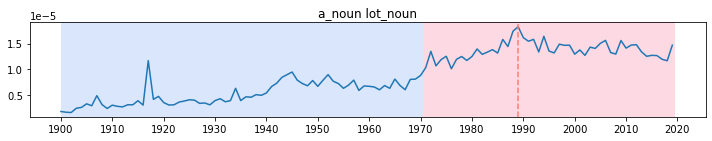

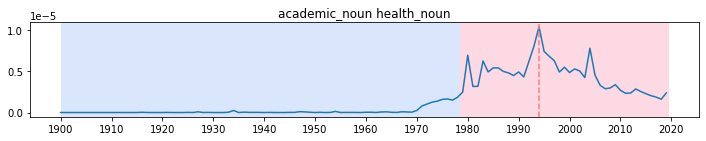

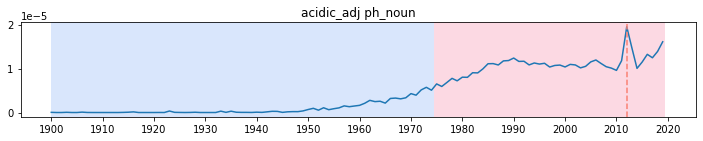

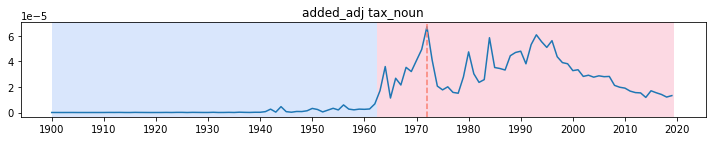

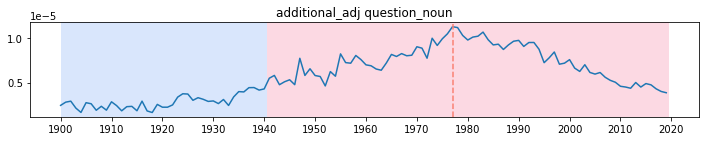

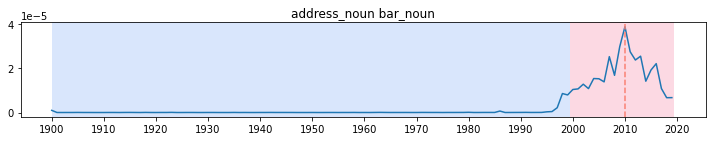

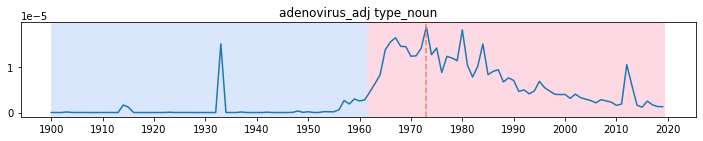

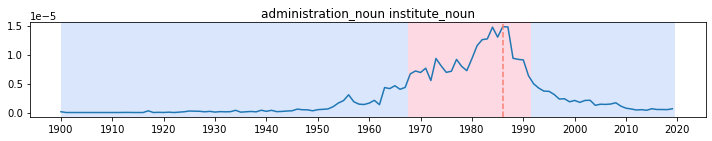

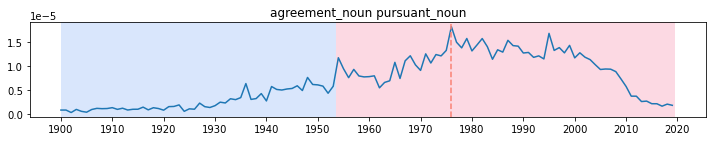

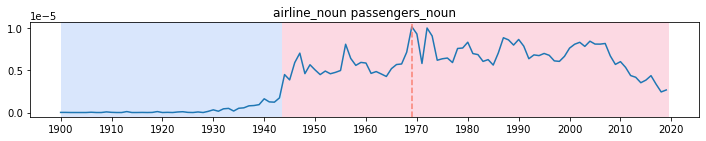

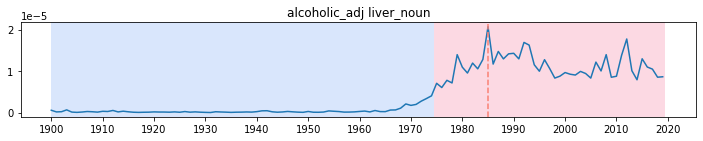

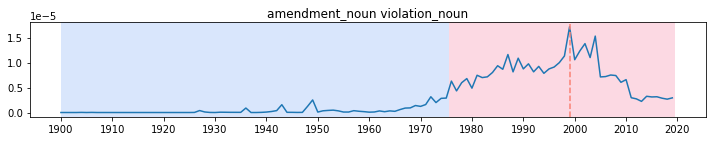

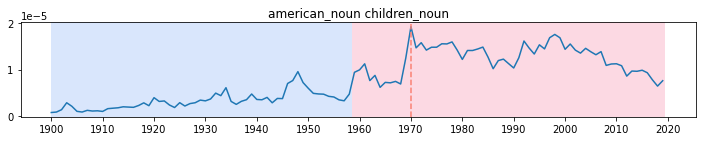

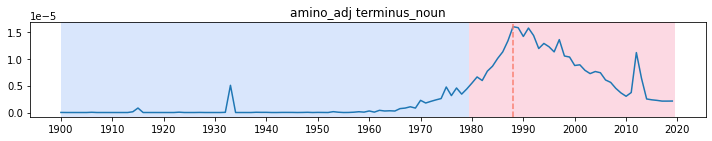

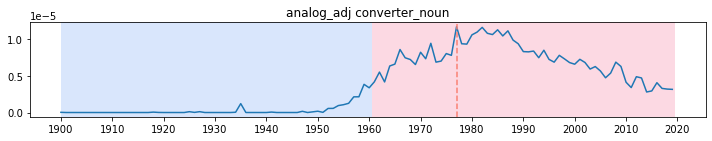

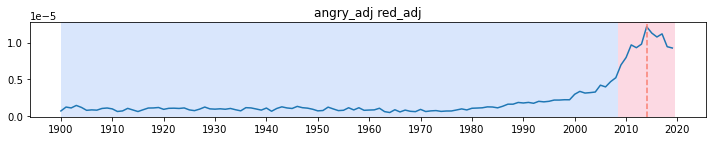

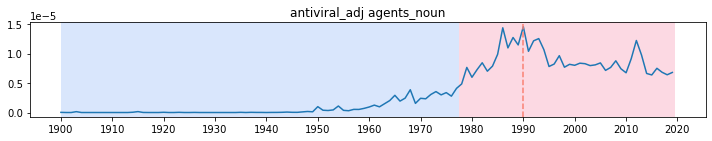

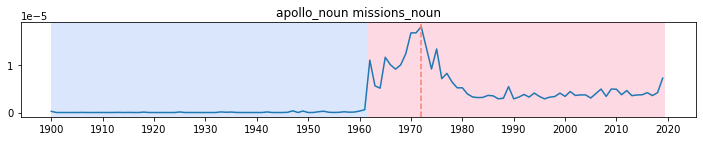

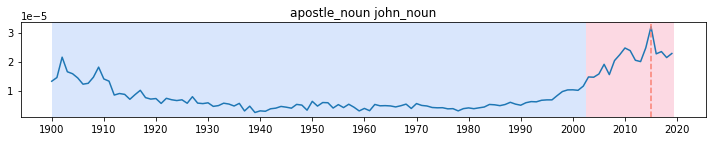

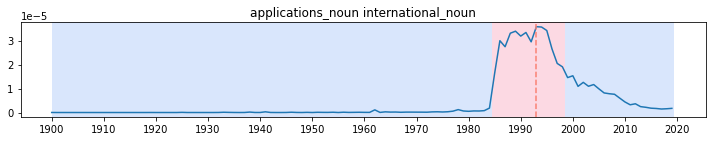

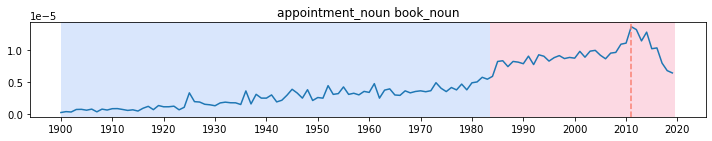

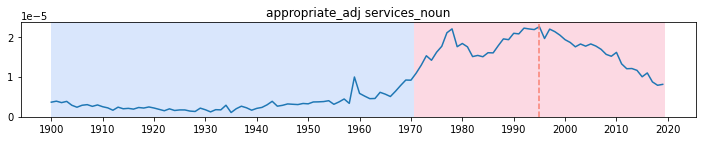

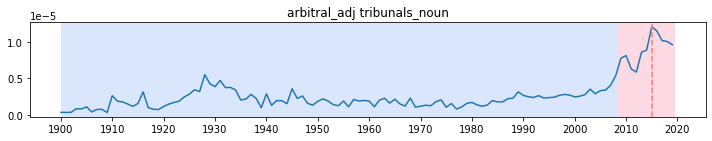

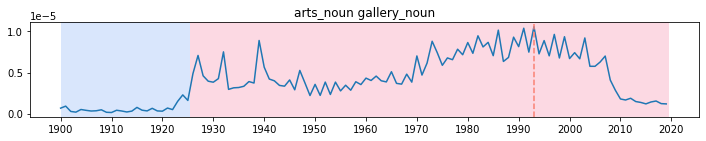

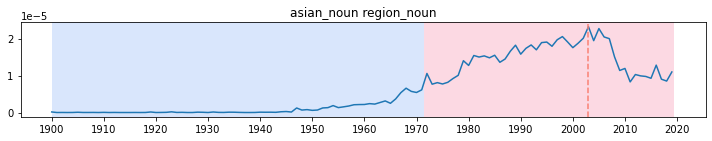

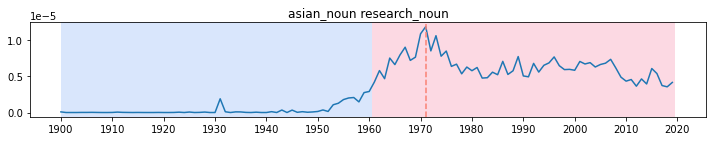

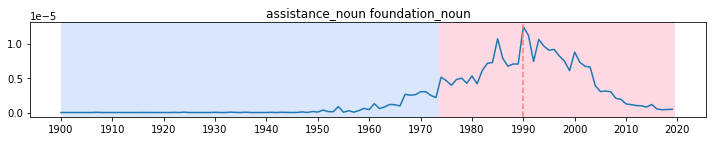

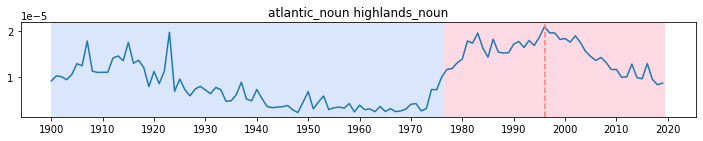

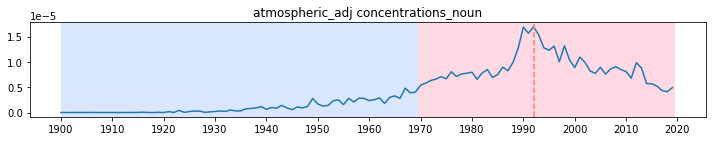

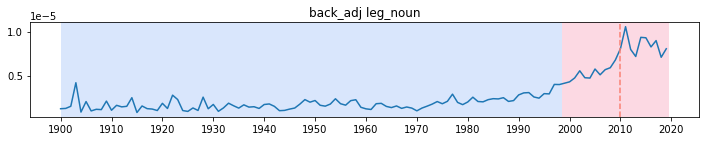

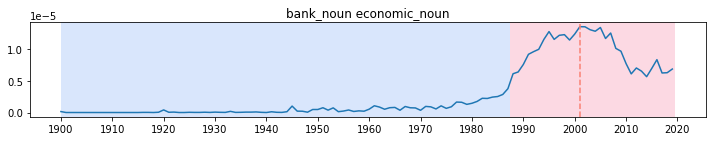

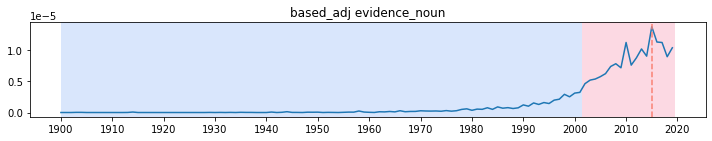

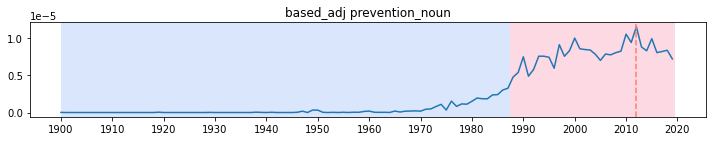

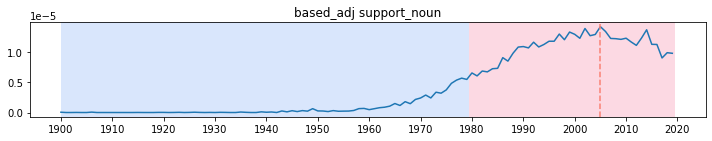

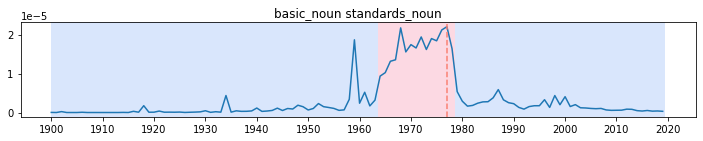

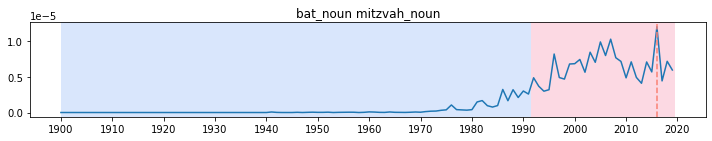

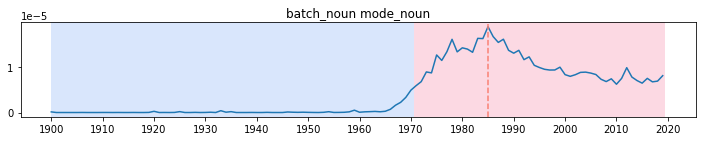

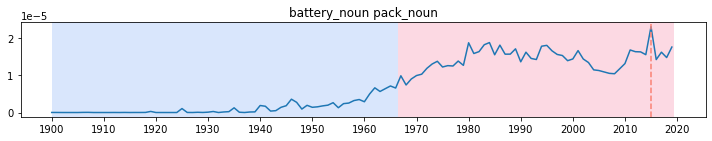

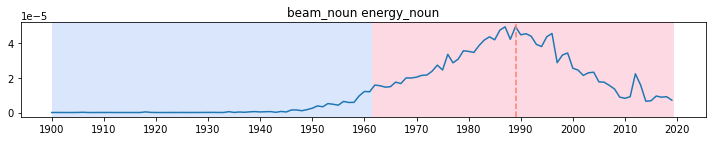

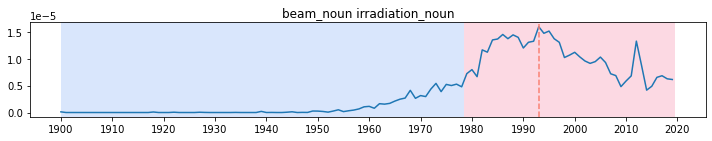

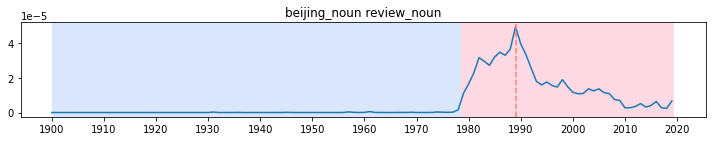

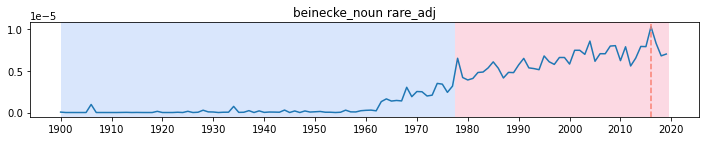

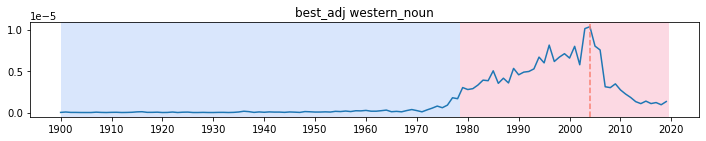

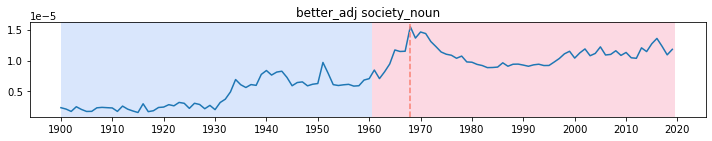

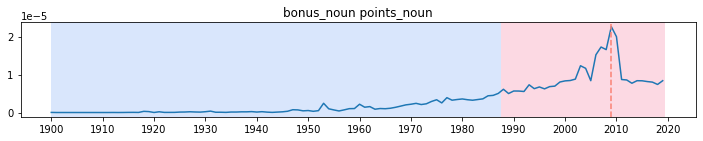

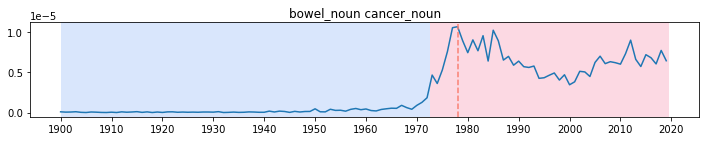

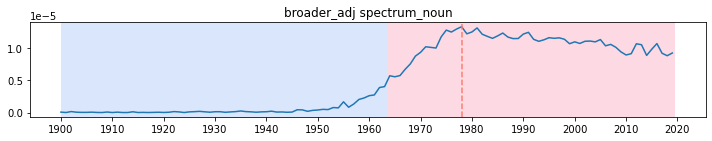

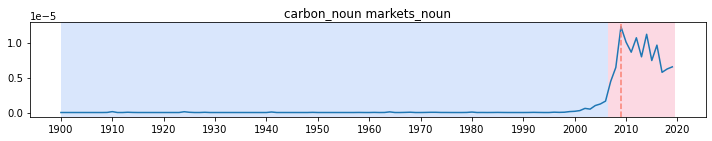

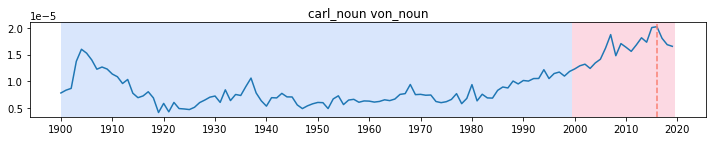

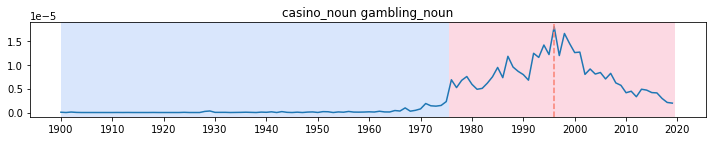

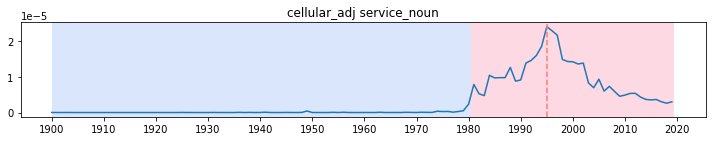

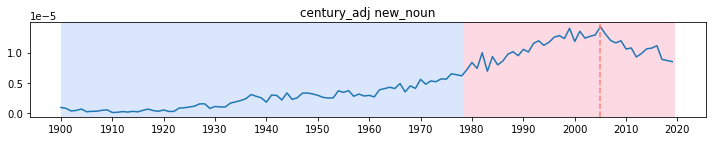

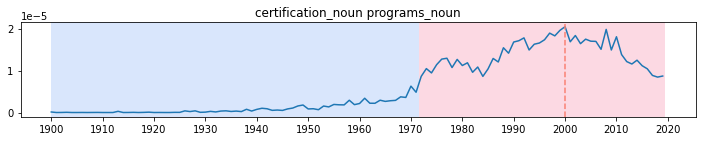

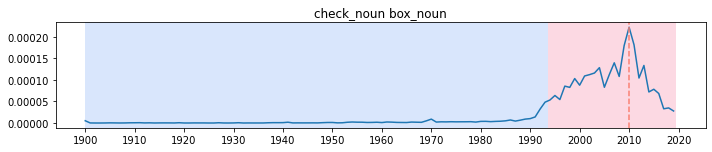

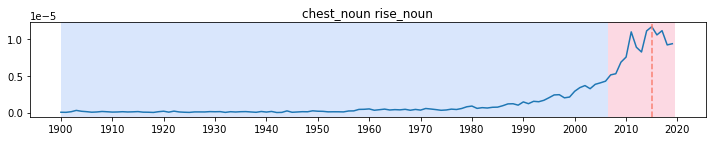

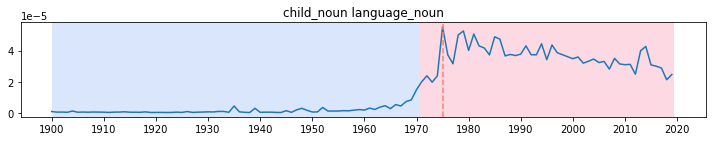

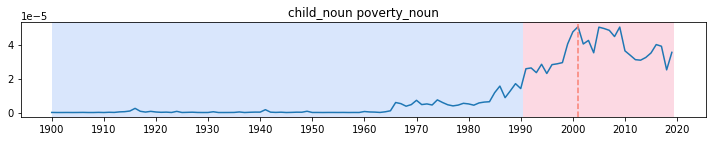

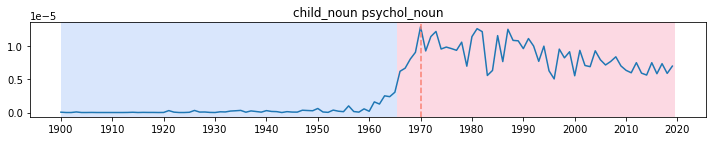

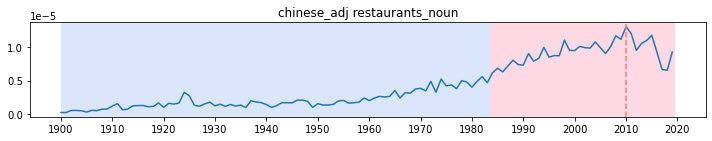

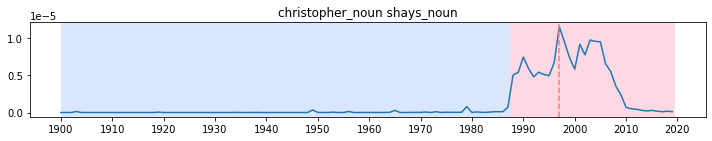

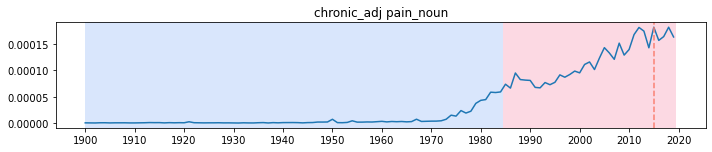

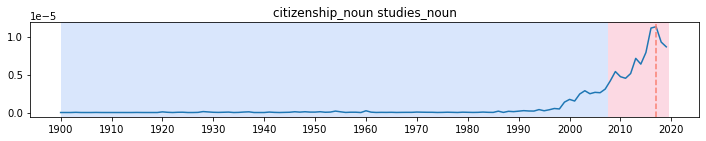

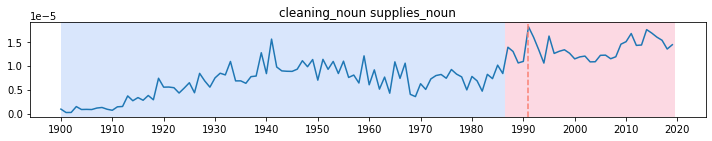

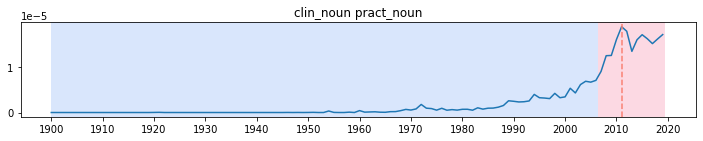

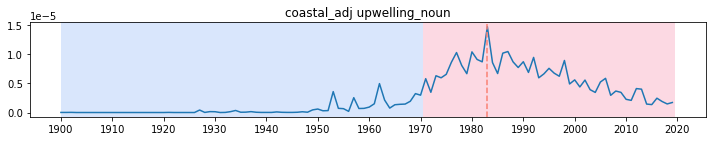

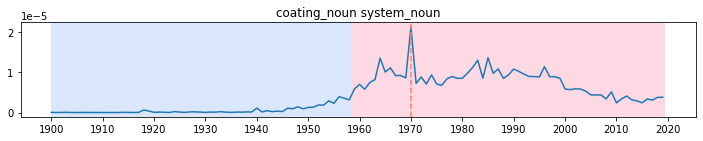

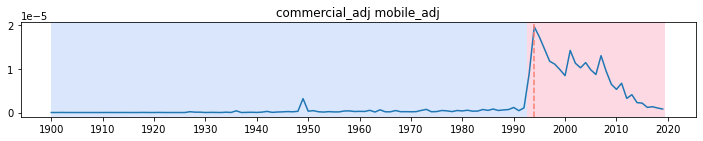

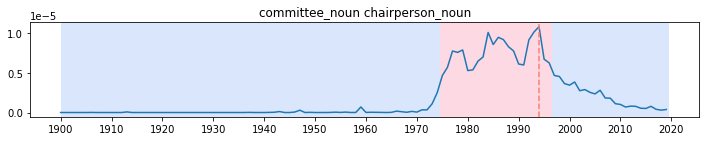

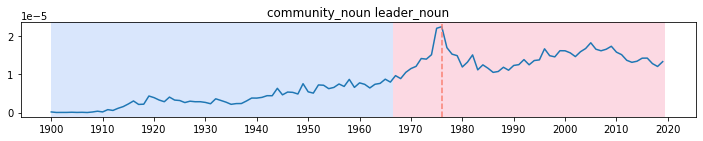

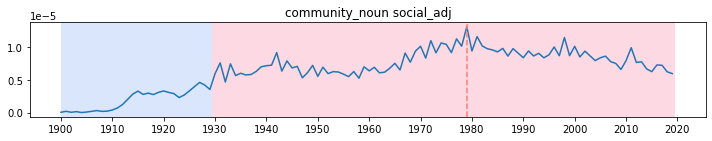

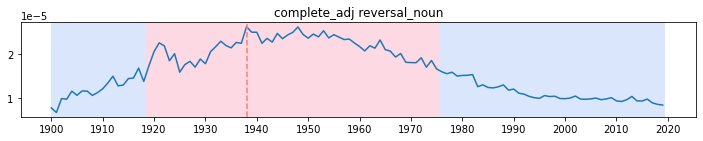

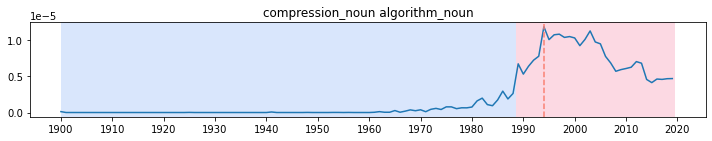

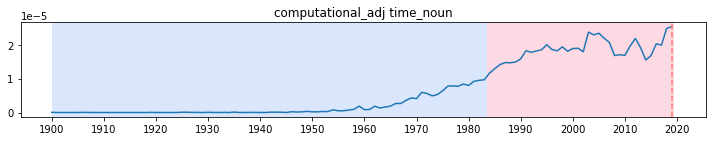

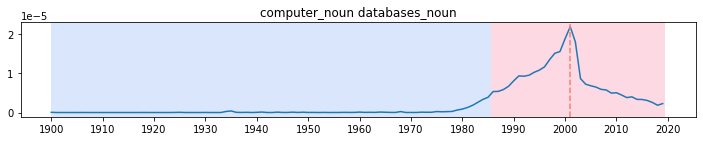

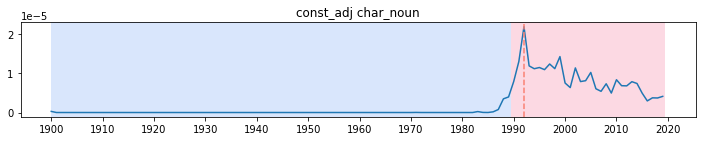

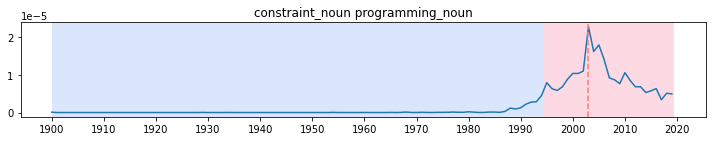

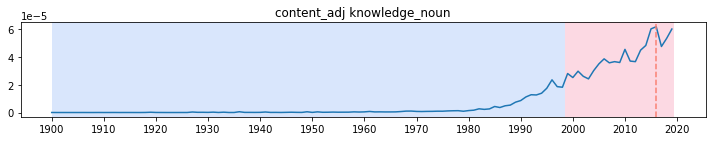

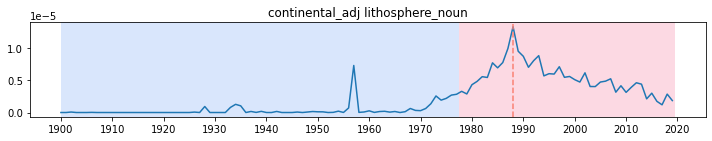

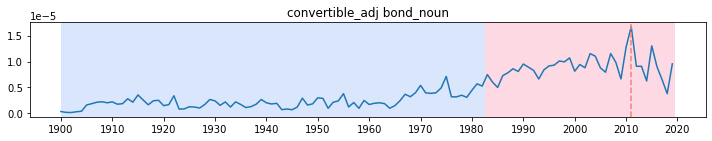

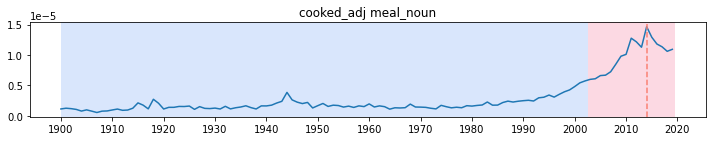

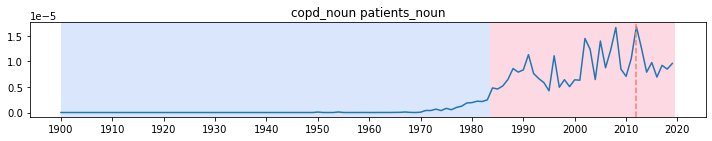

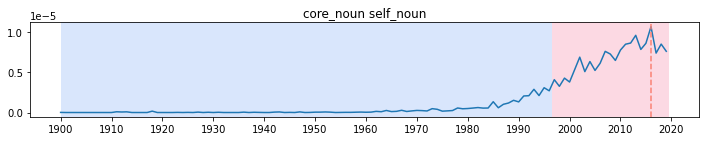

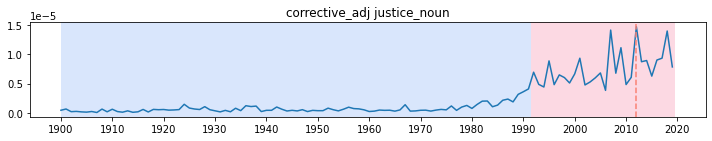

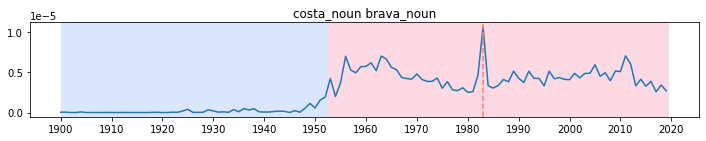

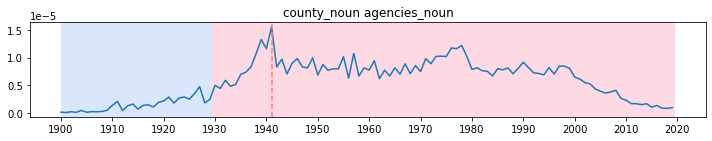

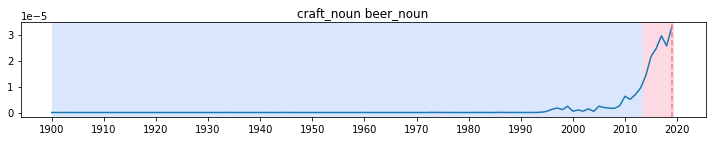

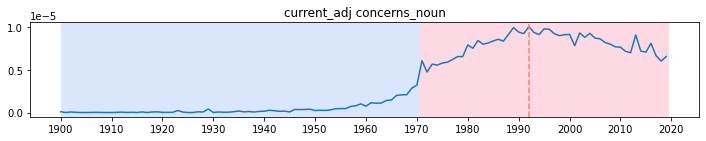

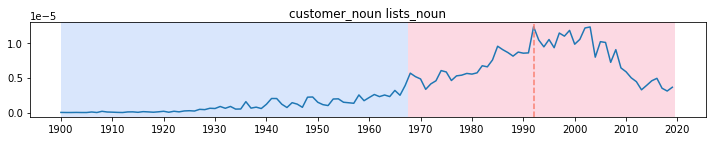

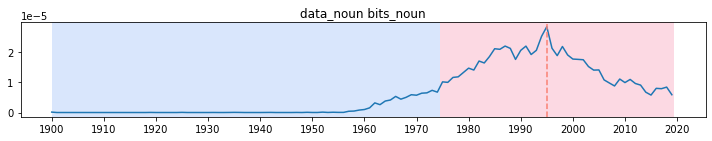

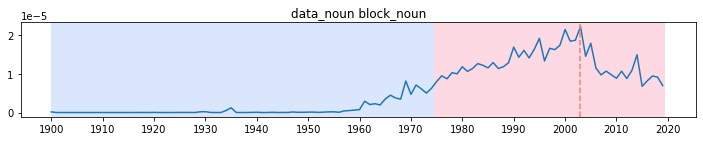

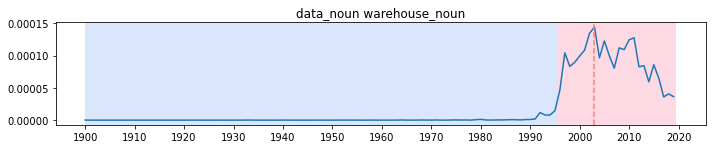

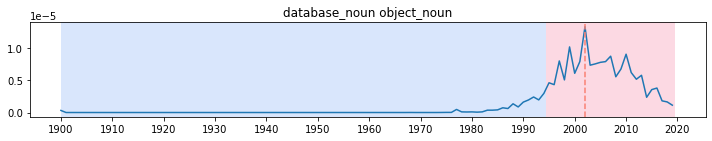

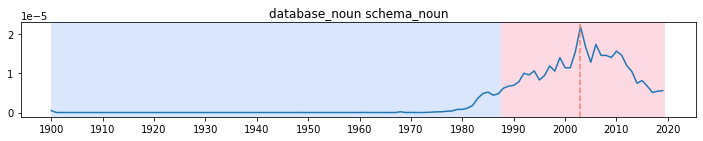

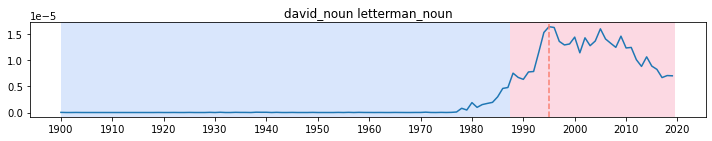

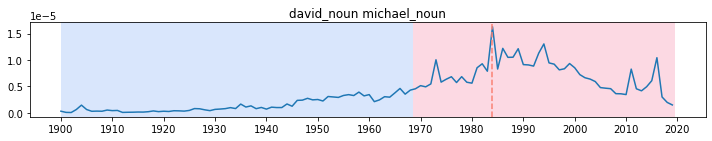

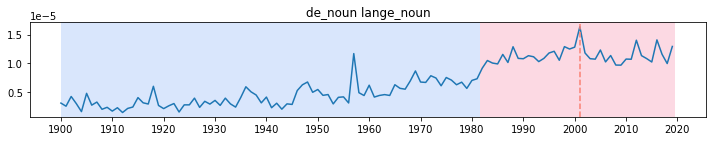

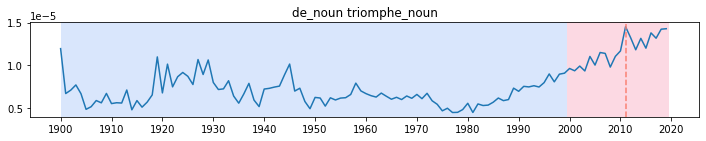

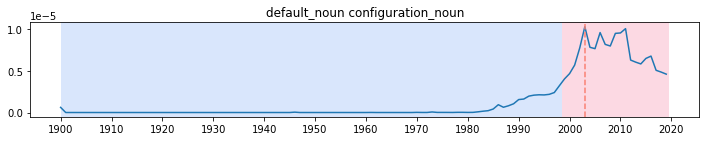

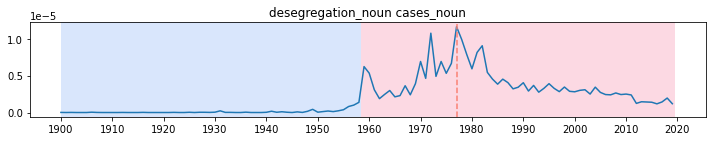

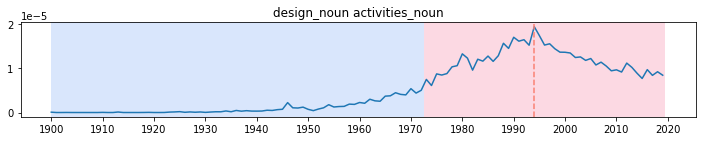

In [87]:
plot_data(label1pd)

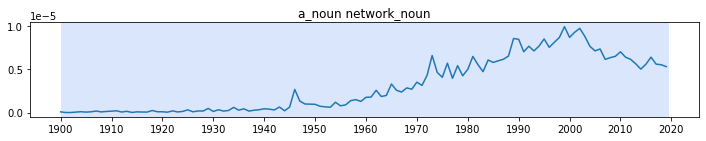

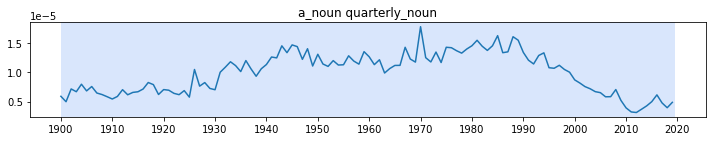

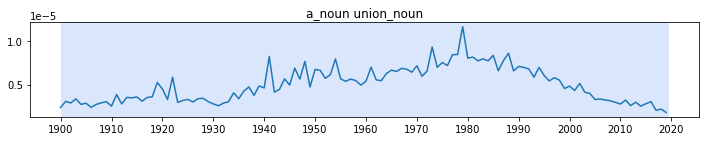

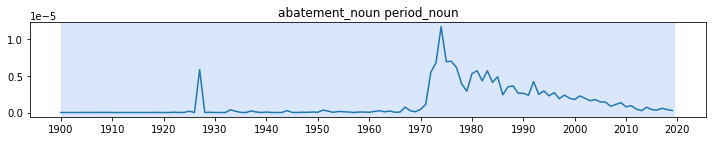

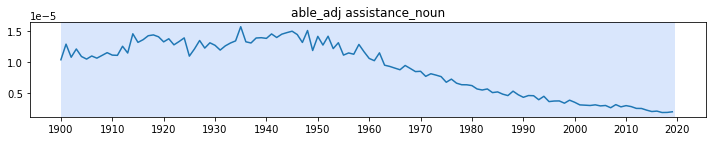

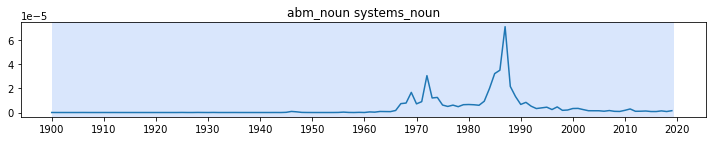

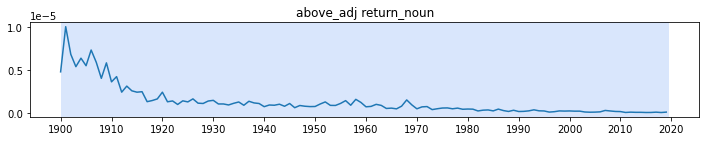

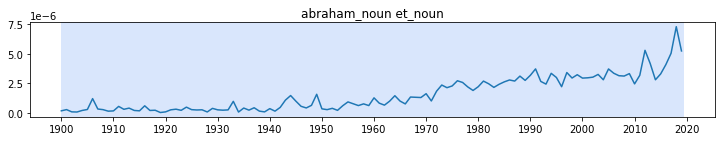

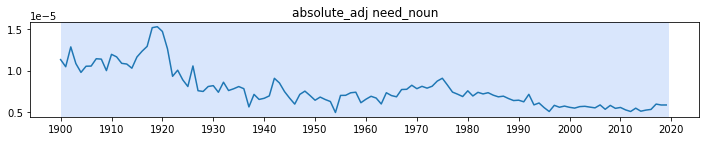

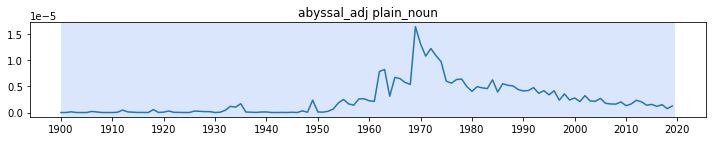

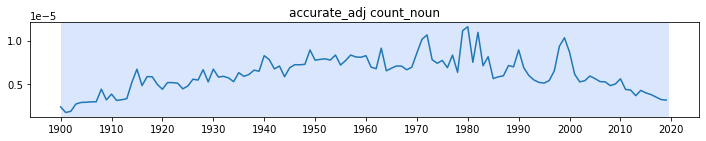

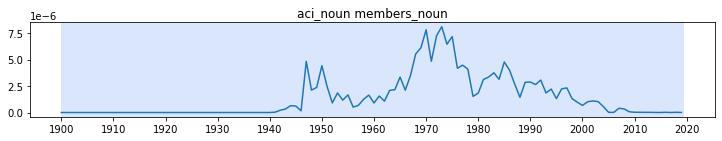

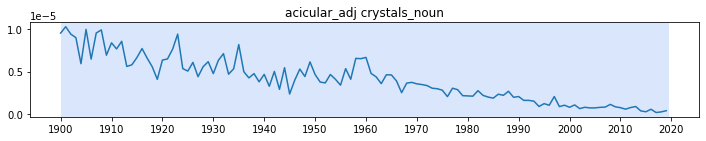

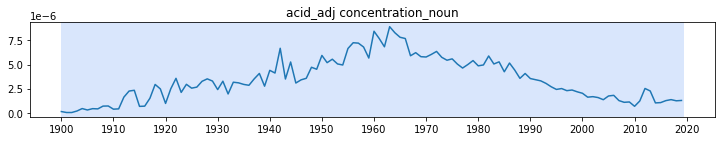

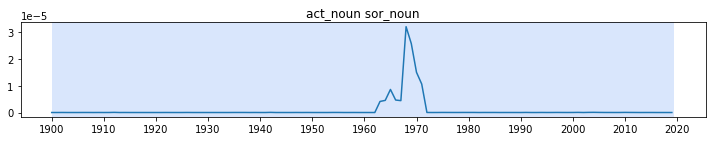

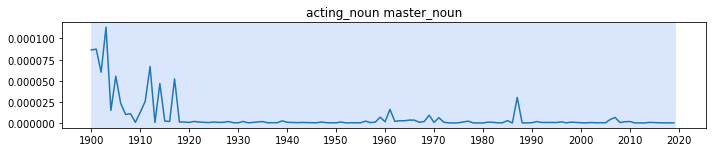

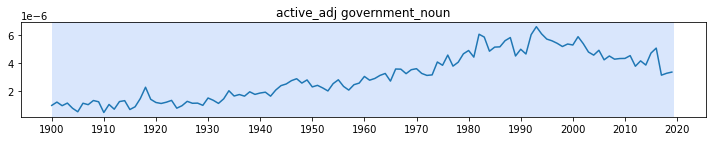

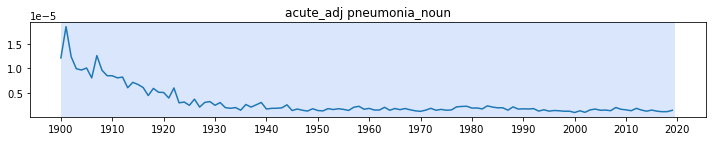

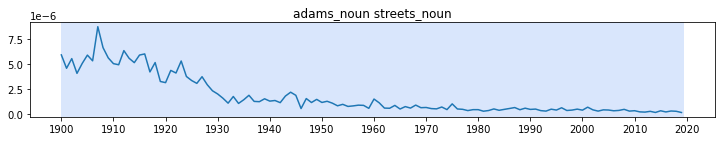

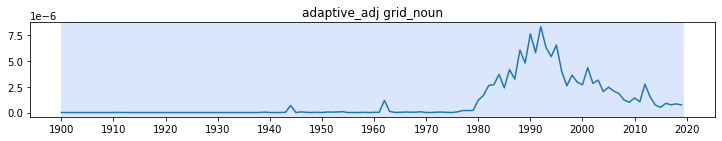

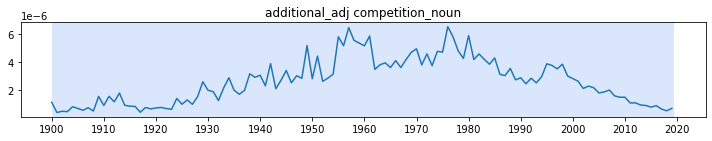

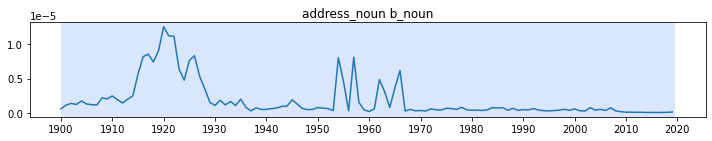

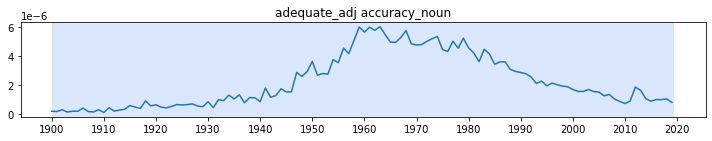

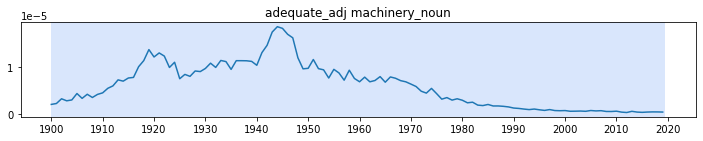

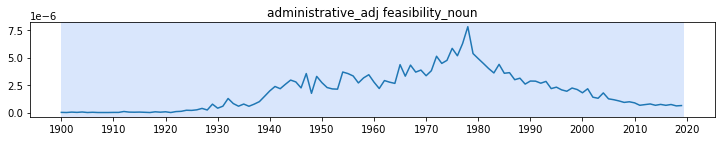

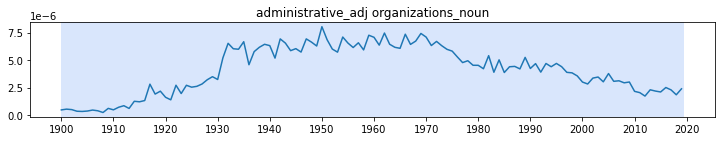

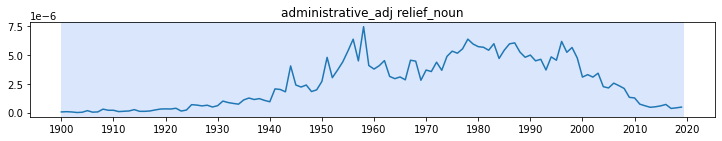

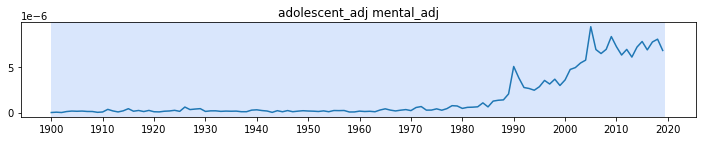

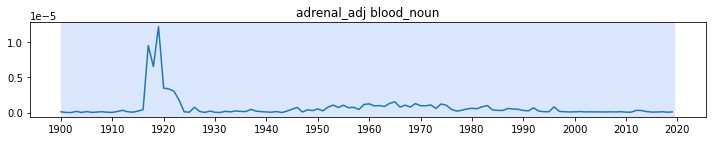

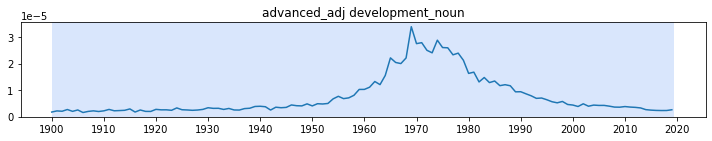

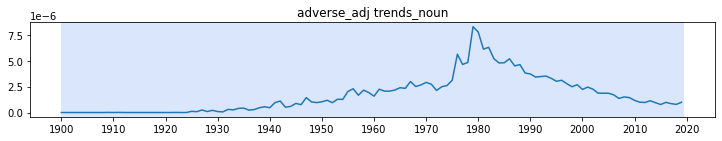

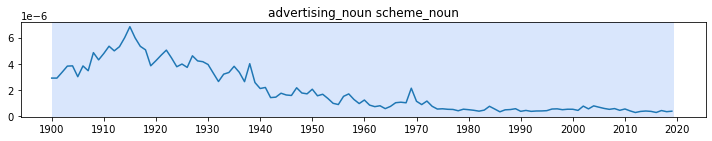

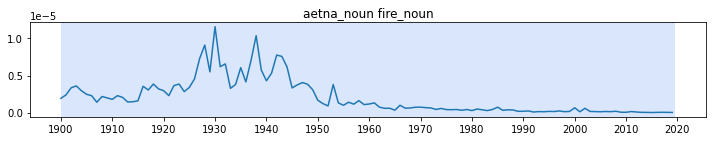

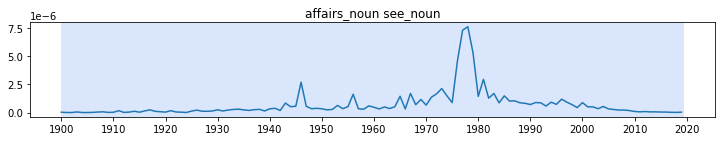

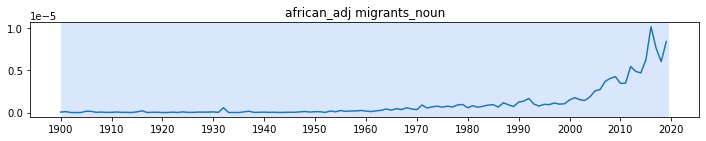

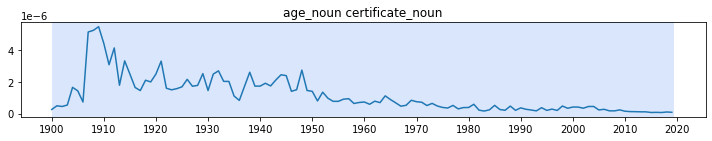

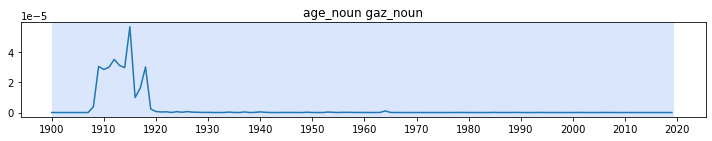

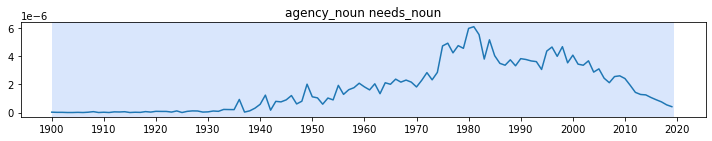

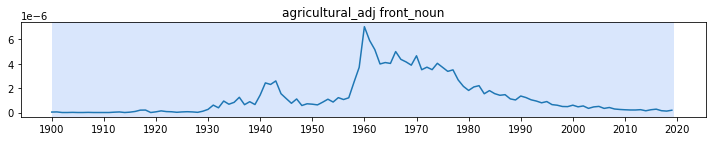

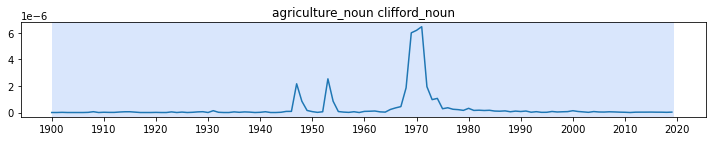

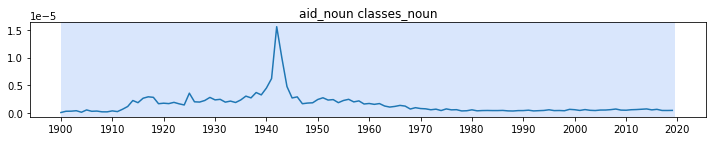

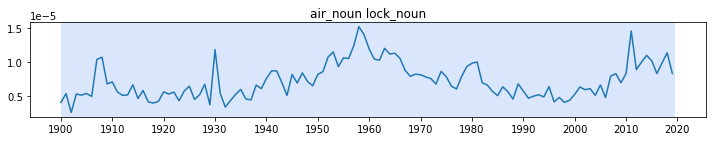

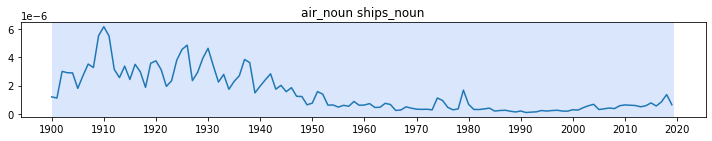

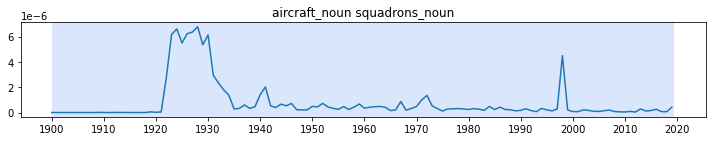

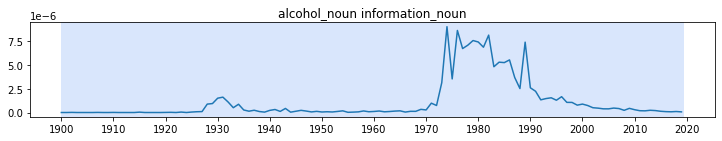

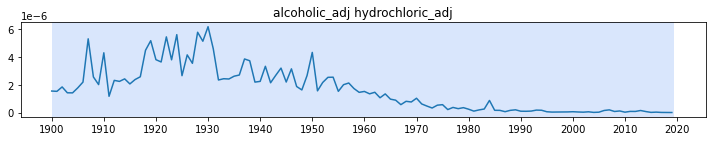

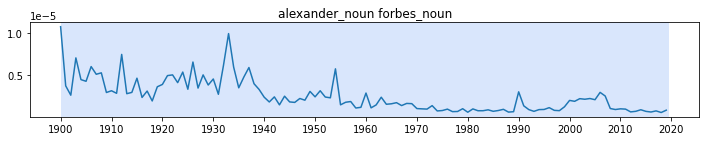

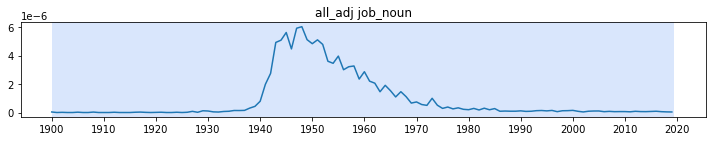

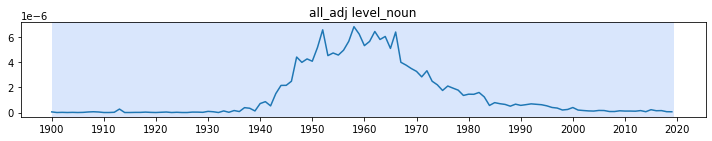

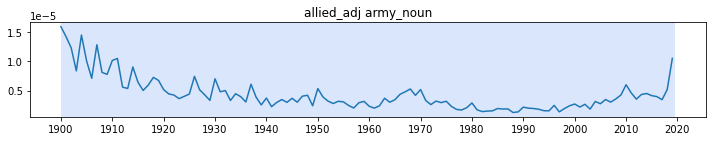

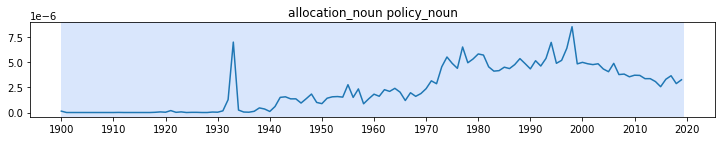

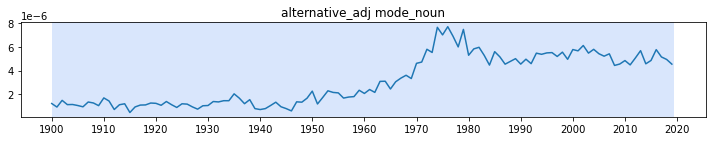

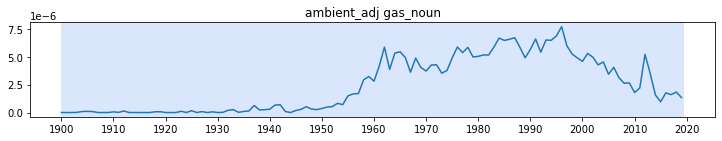

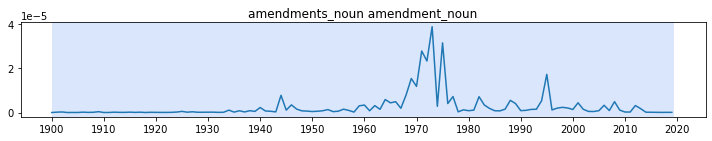

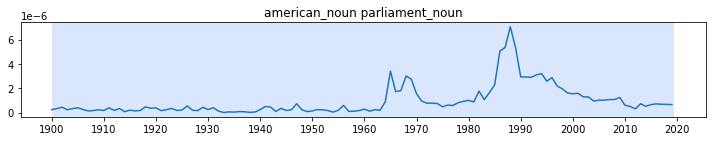

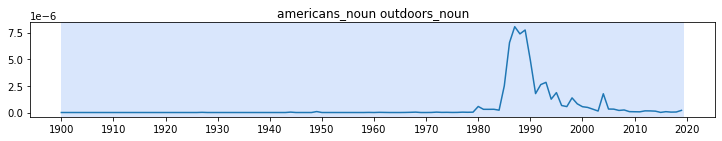

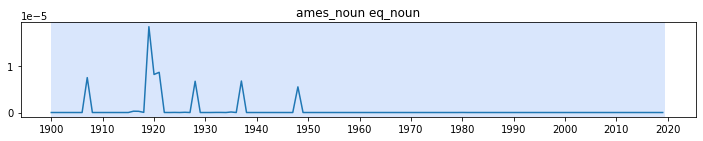

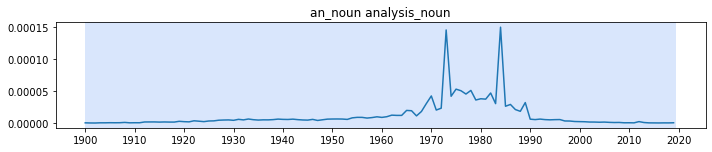

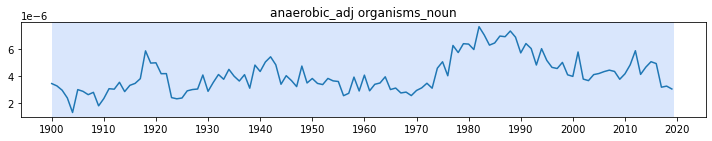

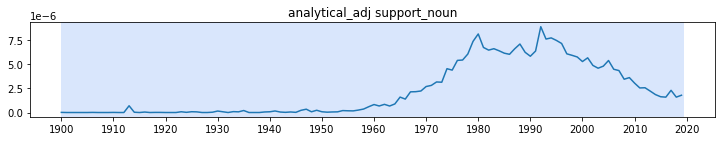

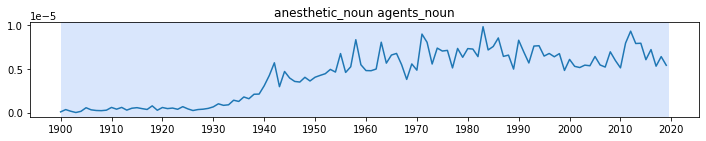

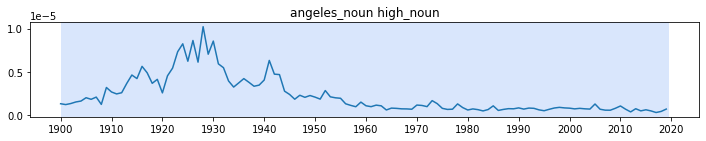

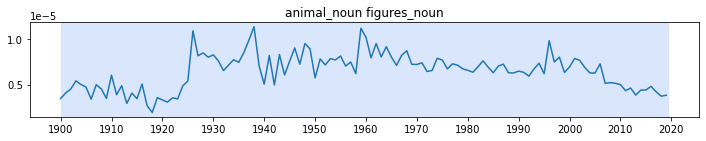

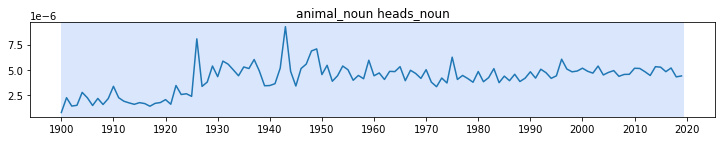

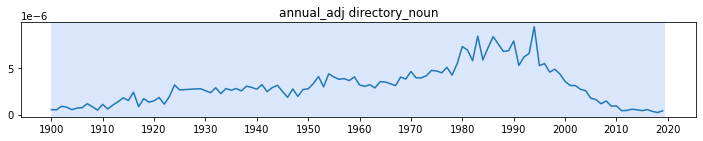

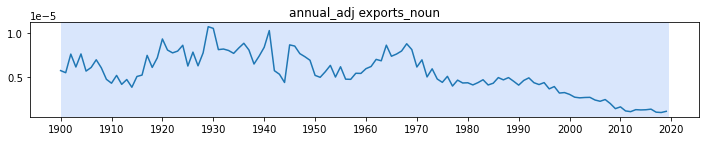

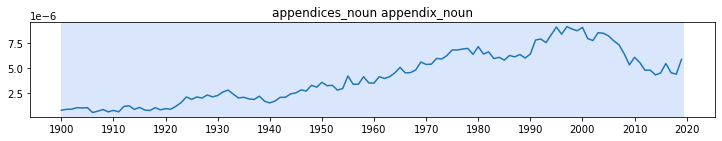

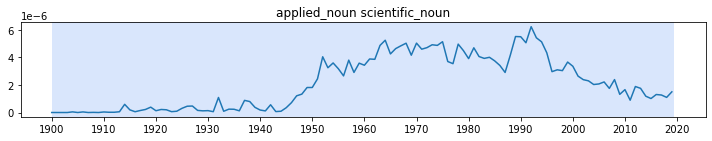

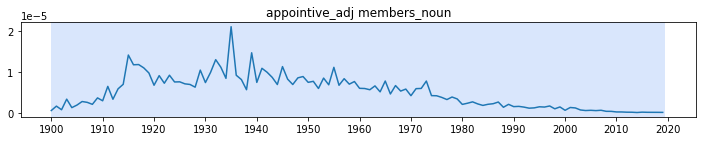

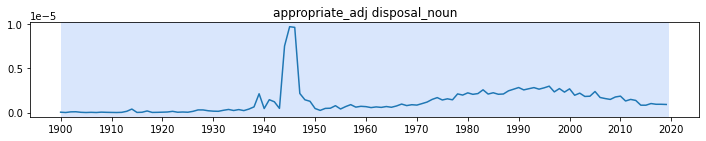

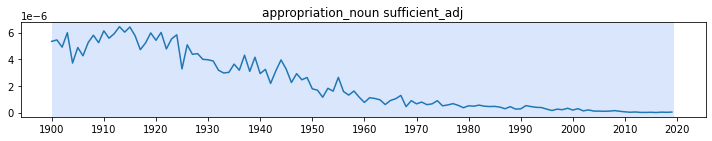

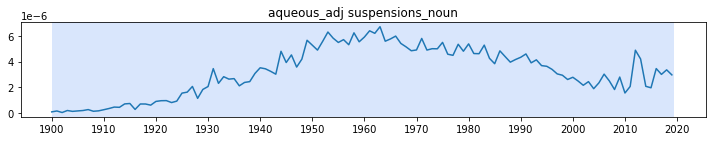

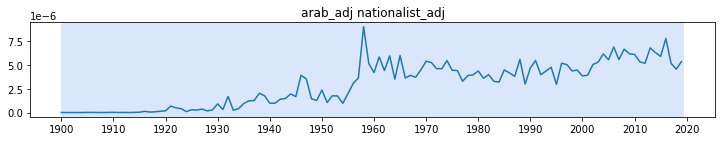

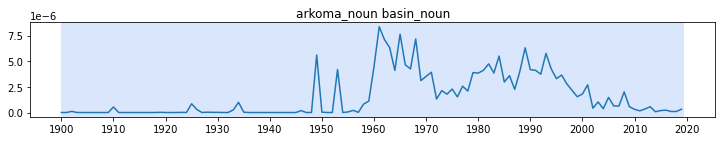

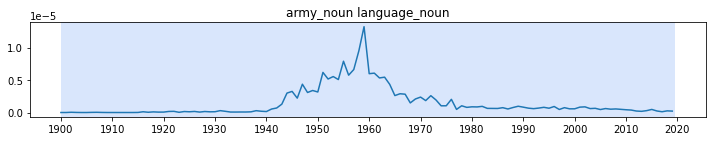

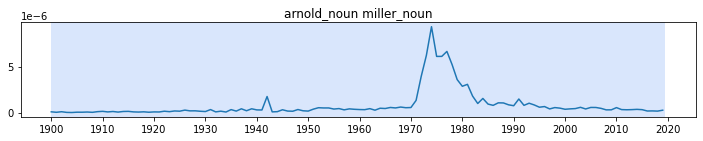

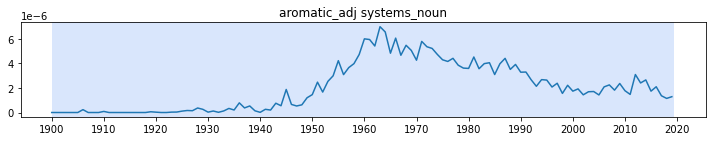

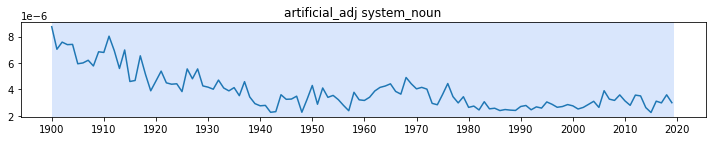

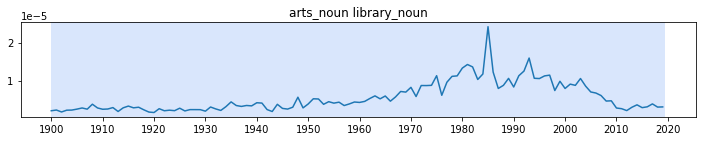

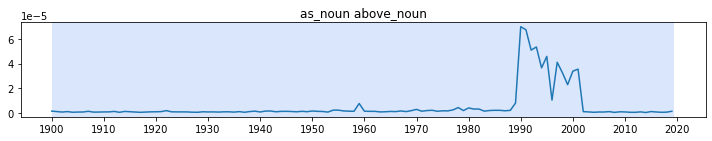

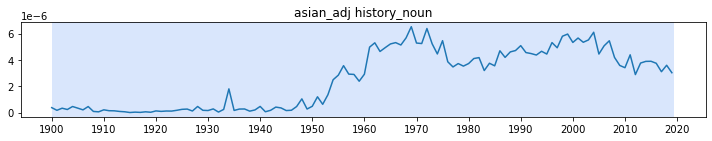

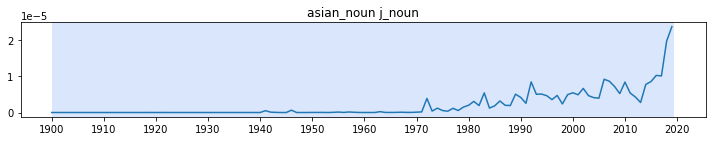

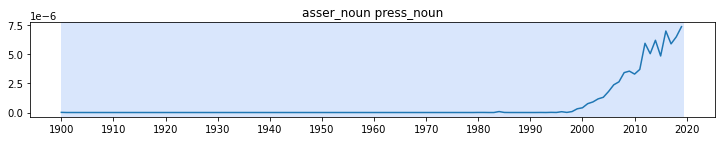

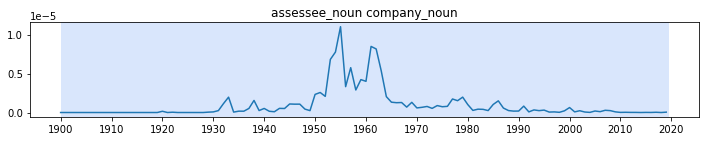

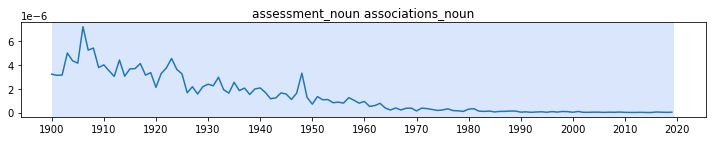

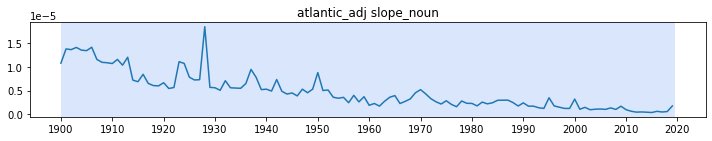

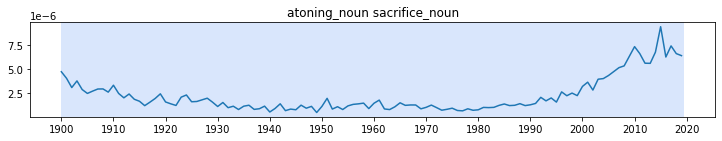

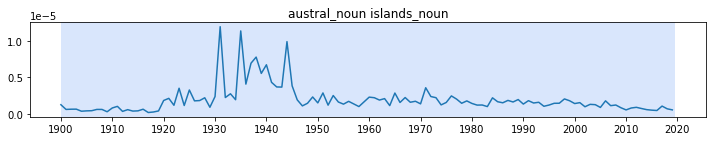

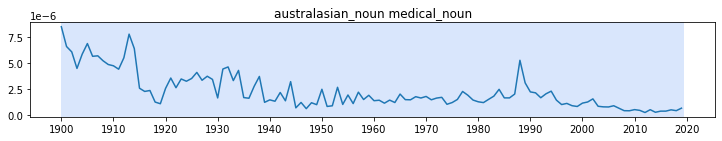

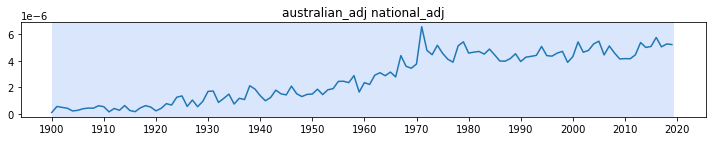

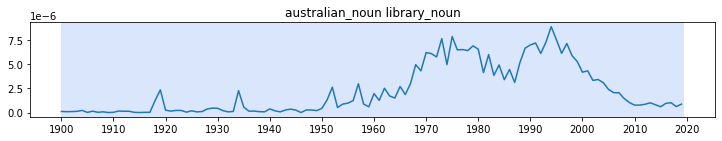

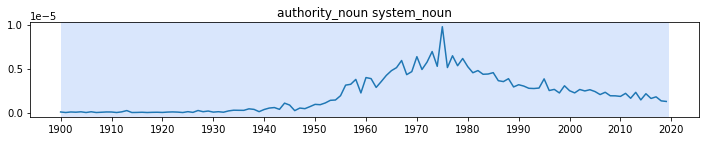

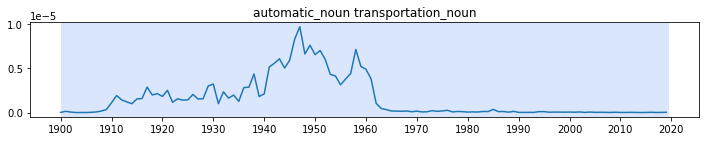

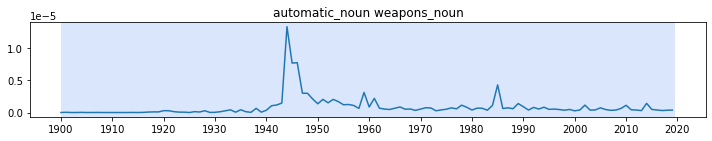

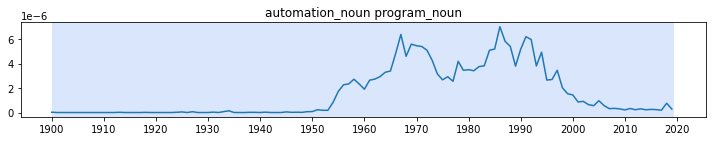

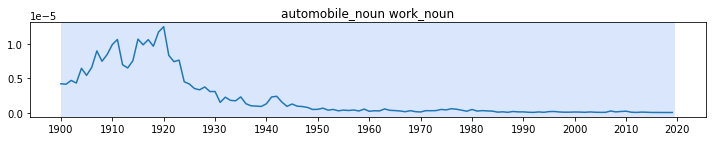

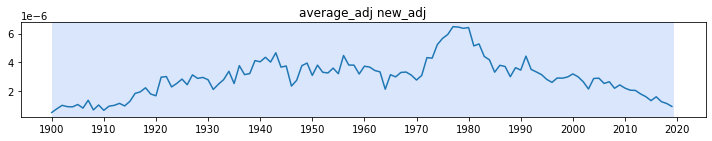

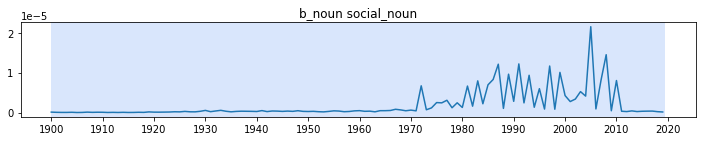

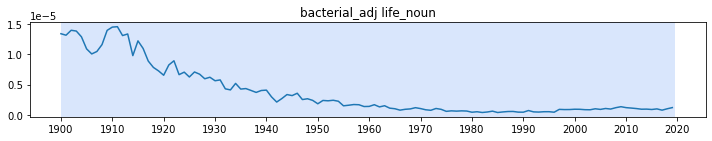

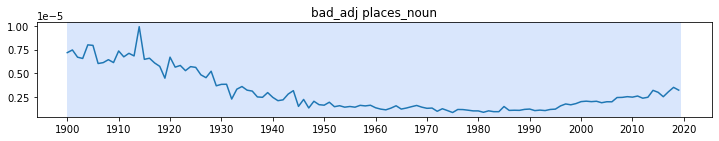

In [88]:
plot_data(label0pd)

### Mainstreaming period distributions

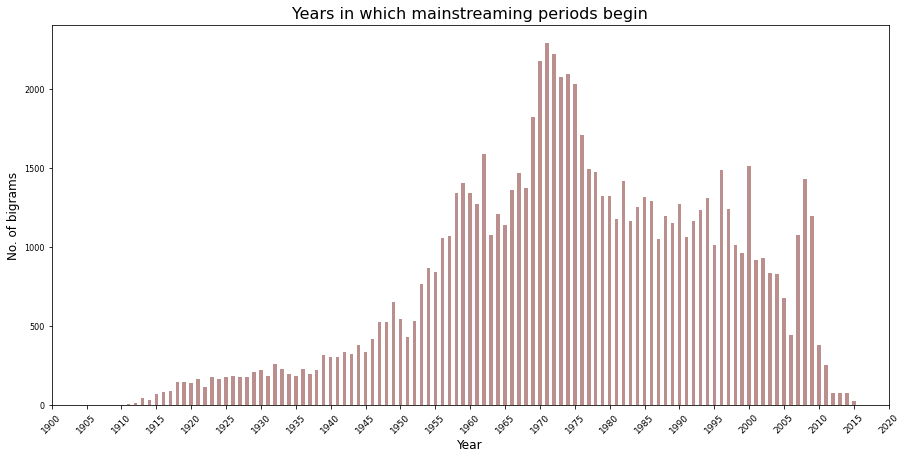

In [16]:
# plot distribution of years in which mainstreaming periods begin 

mainstreamStart = []
for key, val in mainstreamPeriodDict.items():
    mainstreamStart.append(val[0])
    
mainstreamStartpd = pd.DataFrame(mainstreamStart, columns=["mainstream_start"])
mainstreamStartpd['mainstream_start'].value_counts().plot(kind='bar',figsize=(15,7),fontsize='8', color='rosybrown')
plt.xlabel('Year', fontsize='12')
plt.ylabel('No. of bigrams', fontsize='12')
x = np.arange(1900,2021,5)
plt.xticks(x, fontsize=9, rotation=45, labels=x)
plt.title('Years in which mainstreaming periods begin', fontsize='16')
plt.savefig('mainstreaming_years')
plt.show()

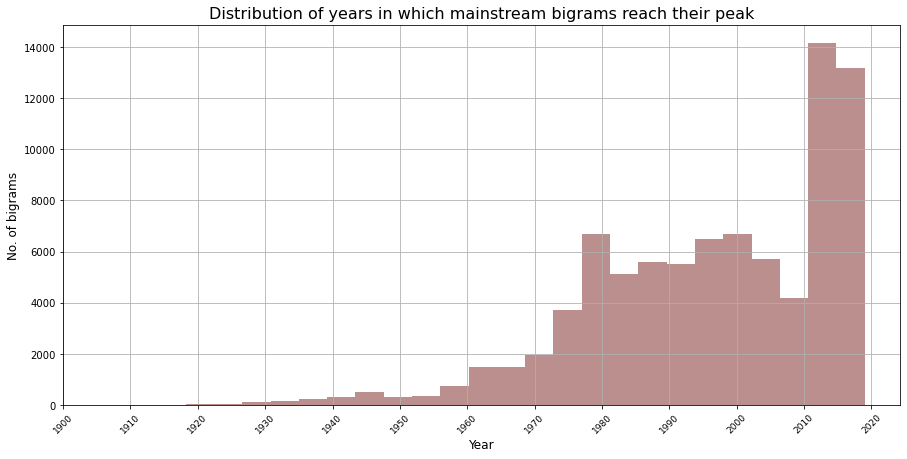

In [45]:
# plot distribution of years in which the bigrams peak 

mainstreamPeak = []
for key, val in mainstreamPeriodDict.items():
    mainstreamPeak.append(val[1])
    
#mainstreamPeakpd = pd.DataFrame(mainstreamPeak, columns=["peak"])
mainstreamPeakpd.hist(bins=25,figsize=(15,7), color='rosybrown')
#mainstreamPeakpd['peak'].value_counts().plot(kind='bar',figsize=(15,7),fontsize='8', color='rosybrown')
plt.xlabel('Year', fontsize='12')
plt.ylabel('No. of bigrams', fontsize='12')
x = np.arange(1900,2021,10)
plt.xticks(x, fontsize=9, rotation=45, labels=x)
plt.title('Distribution of years in which mainstream bigrams reach their peak', fontsize='16')
plt.savefig('peak_years', bbox_inches='tight')
plt.show()